In [2]:
from src.data_ingestion.citation_fetcher import AcademicAPIFactory
from src.data_ingestion.readme_parser import BibTeXExtractor, LinkExtractor, MarkdownHandler, ExtractionFactory
from src.data_ingestion.bibtex_parser import BibTeXFactory, ensure_string

Done by 250212

---

## Simplified and Reliable Data Collection Plan

### Objective:
The goal is to create a reliable and minimal dataset by filtering and validating model cards from multiple sources. We aim to ensure that every card retained in the dataset:
1. Contains valid and verified metadata (BibTeX entries, paper links, GitHub repositories).
2. Has no duplicate entries—retain only the card with the highest `downloads` count if duplicates exist.
3. Downloads the associated data locally and reads it for further processing.
4. Annotates the dataset with citation information to build a **citation graph** that reflects inter-card relationships (i.e., a card’s associated paper cites another card's associated paper).  

We will leverage a **Citation Graph API** to annotate and establish these relationships.

---

### Step-by-Step Plan:

#### 1. **Data Filtering Phase**
   - **Input Sources:** 
     - card_readme content
     - BibTeX entries
     - GitHub repo READMEs
   - **Filtering Criteria:**
     - Remove any card that lacks all of the following:
       - Paper link (arXiv, DOI, or PDF)
       - BibTeX entry
       - GitHub link
     - Eliminate duplicate cards; keep the one with the highest `downloads` count.
     - Validate remaining links to ensure they are functional and non-placeholder.

#### 2. **Data Downloading Phase**
   - Download the related resources (PDFs, code repos, etc.).
   - Organize and read the downloaded content from the local directory for further processing.

#### 3. **Citation Annotation Phase**
   - Use the **Citation Graph API** to analyze and annotate each card by identifying citations between associated papers.
   - Establish inter-card relationships (i.e., identify which card’s paper cites another).

#### 4. **Final Dataset Construction**
   - Create a structured and annotated dataset that includes:
     - Valid and non-duplicate card data.
     - Citation relationships between cards.
     - Metadata for each card (downloads, likes, BibTeX, and link status).
---


In [28]:
import pandas as pd
data_type = 'modelcard'
df_split_temp = pd.read_parquet(f"data/{data_type}_step3_markdown_gated.parquet")

In [ ]:
import pandas as pd
data_type = 'modelcard'
df_split_temp = pd.read_parquet(f"data/{data_type}_step4_markdown_gated.parquet")

In [29]:
# Filter: 
# - extracted_bibtex is not null or an empty list
# - contains_markdown_table is True
# - they are valid, unique

import pandas as pd
# Columns and filtering keys
key_bibtex = "extracted_bibtex"
key_markdown = "contains_markdown_table"
key_markdown_table = "extracted_markdown_table"
key_downloads = "downloads"
# Convert extracted_bibtex and extracted_markdown_table to tuples for uniqueness checks
df_split_temp["extracted_bibtex_tuple"] = df_split_temp[key_bibtex].apply(lambda x: tuple(x) if isinstance(x, list) else (x,))
df_split_temp["extracted_markdown_table_tuple"] = df_split_temp[key_markdown_table].apply(lambda x: tuple(x) if isinstance(x, list) else (x,))
# First Layer: Initial filtering based on your specified conditions
filtered_df = df_split_temp[
    df_split_temp[key_bibtex].notnull() & 
    (df_split_temp[key_bibtex].apply(lambda x: len(x) > 0)) & 
    (df_split_temp[key_markdown] == True)
]
print("Number of rows after first filter:", len(filtered_df))
# Second Layer: Remove duplicates based on markdown table and downloads
filtered_df = filtered_df.sort_values(by=key_downloads, ascending=False)
unique_by_markdown = filtered_df.drop_duplicates(subset=["extracted_markdown_table_tuple"], keep="first")
# Final Step: Ensure no duplicates for the combination of bibtex and markdown table
final_unique_df = unique_by_markdown.drop_duplicates(subset=["extracted_bibtex_tuple", "extracted_markdown_table_tuple"])
# Display the final result
print("Number of unique rows after full filtering:", len(unique_by_markdown), len(final_unique_df))


KeyError: 'extracted_bibtex'

In [ ]:
import os
from tqdm import tqdm

# Assuming df_split_temp has a column "csv_path" storing the local CSV table paths
key_csv_path = "csv_path"
valid_csv_df = unique_by_markdown[unique_by_markdown[key_csv_path].apply(lambda x: os.path.exists(x) if isinstance(x, str) else False)]
num_tables = len(valid_csv_df)
num_cols = 0
total_rows = 0
for csv_file in tqdm(valid_csv_df[key_csv_path]):
    try:
        df = pd.read_csv(csv_file)
        num_cols += df.shape[1]  # Number of columns in the CSV
        total_rows += df.shape[0]  # Number of rows in the CSV
    except Exception as e:
        print(f"Error reading {csv_file}: {e}")
avg_rows = total_rows / num_tables if num_tables > 0 else 0
new_row = {
    "Benchmark": "SciLake",
    "# Tables": num_tables,
    "# Cols": num_cols,
    "Avg # Rows": avg_rows,
    "Size (GB)": "nan"
}
benchmark_data = {
    "Benchmark": ["SANTOS Small", "TUS Small", "TUS Large", "SANTOS Large", "WDC"],
    "# Tables": [550, 1530, 5043, 11090, 50000000],
    "# Cols": [6322, 14810, 54923, 123477, 250000000],
    "Avg # Rows": [6921, 4466, 1915, 7675, 14],
    "Size (GB)": [0.45, 1, 1.5, 11, 500]
}

# Create benchmark DataFrame and append new row
benchmark_df = pd.DataFrame(benchmark_data)
benchmark_df = pd.concat([benchmark_df, pd.DataFrame([new_row])], ignore_index=True)
benchmark_df

In [4]:
#from utils import LinkExtractor, BibTeXExtractor, ExtractionFactory
import pandas as pd
df_split_temp['link_info'] = df_split_temp['card_readme'].apply(
    lambda x: LinkExtractor().extract_links(str(x)) if pd.notnull(x) else {"pdf_link": None, "github_link": None, "all_links": []}
)
df_split_temp['pdf_link'] = df_split_temp['link_info'].apply(lambda x: x['pdf_link'])
df_split_temp['github_link'] = df_split_temp['link_info'].apply(lambda x: x['github_link'])


In [5]:
# Apply the extraction function to each row in the specified column
df_split_temp["extracted_bibtex"] = df_split_temp["card_readme"].apply(lambda x: BibTeXExtractor().extract(x) if isinstance(x, str) else [])
df_split_temp["extracted_bibtex"].head(10)

0                                                   []
1                                                   []
2                                                   []
3    [@article{DBLP:journals/corr/abs-1810-04805, a...
4    [@article{DBLP:journals/corr/abs-1911-02116, a...
5    [@misc{radford2022whisper, doi = {10.48550/ARX...
6                                                   []
7                                                   []
8                                                   []
9    [@misc{grosman2021xlsr53-large-english, title=...
Name: extracted_bibtex, dtype: object

In [15]:
# load the data
import pandas as pd
data_type = 'modelcard'
df_split_temp = pd.read_parquet(f"data/{data_type}_step4_markdown_gated.parquet")

 86%|████████▌ | 130019/151086 [04:03<00:35, 595.01it/s]

Error reading cleaned_markdown_csvs/yasakoko_NoAI-Diffusion-variety_markdown_553967.csv: No columns to parse from file


 92%|█████████▏| 138599/151086 [04:35<00:26, 464.12it/s]

Error reading cleaned_markdown_csvs/OzzyGT_melvyn_markdown_735407.csv: No columns to parse from file


 95%|█████████▍| 142861/151086 [04:45<00:15, 534.63it/s]

Error reading cleaned_markdown_csvs/yuneun92_koCSN_SAPR_markdown_811179.csv: No columns to parse from file


100%|██████████| 151086/151086 [05:05<00:00, 494.80it/s]


,Benchmark,# Tables,# Cols,Avg # Rows,Size (GB)
0,SANTOS Small,550,6322,6921.000000,0.45
1,TUS Small,1530,14810,4466.000000,1.0
2,TUS Large,5043,54923,1915.000000,1.5
3,SANTOS Large,11090,123477,7675.000000,11.0
4,WDC,50000000,250000000,14.000000,500.0
5,SciLake,151086,898350,18.194154,nan


In [19]:
df_split_temp['csv_path'].notnull().sum()

np.int64(151086)

In [22]:
df_split_temp[df_split_temp['csv_path'].notnull()]['csv_path']

0          cleaned_markdown_csvs/sentence-transformers_al...
2          cleaned_markdown_csvs/sentence-transformers_al...
3          cleaned_markdown_csvs/google-bert_bert-base-un...
5          cleaned_markdown_csvs/openai_whisper-large-v2_...
9          cleaned_markdown_csvs/jonatasgrosman_wav2vec2-...
                                 ...                        
1108728    cleaned_markdown_csvs/touhidulislam_BERTweet_r...
1108730    cleaned_markdown_csvs/tttx_problem226_model_au...
1108739    cleaned_markdown_csvs/featherless-ai-quants_gr...
1108742    cleaned_markdown_csvs/tttx_problem301_model_mo...
1108757    cleaned_markdown_csvs/mradermacher_Mistral-qui...
Name: csv_path, Length: 151086, dtype: object

In [7]:
### double check the extracted markdown first



In [ ]:
import json
import pandas as pd
import re
from tqdm import tqdm

def clean_title(title):
    """Removes unnecessary BibTeX characters like {} and trims spaces."""
    if title:
        return re.sub(r"[{}]", "", title).strip()
    return title

def sync_process_queries(df, doi_col="doi", title_col="title"):
    """
    Synchronously processes each row with search_and_fetch_info().
    Returns references, citations, and success flags for each row.
    """
    results = []
    total_success = 0
    total_failed = 0
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Rows"):
        parsed_bibtex_entries = row["parsed_bibtex_tuple_list"]
        if not isinstance(parsed_bibtex_entries, list) or len(parsed_bibtex_entries) == 0:
            print(f"[Row {idx}] ❌ No valid BibTeX entries.")
            results.append((json.dumps([]), json.dumps([]), False))
            total_failed += 1
            continue
        references, citations = [], []
        success = False
        for parsed_data in parsed_bibtex_entries:
            if not isinstance(parsed_data, dict):
                continue
            doi = parsed_data.get("doi")
            title = parsed_data.get("title")
            # ✅ Fix: Clean title and lowercase DOI
            title = clean_title(title)
            if doi:
                doi = doi.lower().strip()
            print(f"[Row {idx}] 🔎 Searching for: DOI={doi}, Title={title}")
            try:
                info_dict = search_and_fetch_info(doi=doi, title=title)
                if info_dict is not None:
                    references = info_dict.get("references", [])
                    citations = info_dict.get("citations", [])
                    # ✅ Debugging: Print when few references/citations are found
                    if len(references) < 3 or len(citations) < 3:
                        print(f"[Row {idx}] ⚠️ Low results! Only {len(references)} references & {len(citations)} citations.")
                    print(f"[Row {idx}] ✅ Found {len(references)} references and {len(citations)} citations.")
                    success = True
                    total_success += 1
                    break
                else:
                    print(f"[Row {idx}] ⚠️ No results found.")
                    total_failed += 1
            except Exception as e:
                print(f"[Row {idx}] ❌ Error: {e}")
                total_failed += 1
        results.append((json.dumps(references), json.dumps(citations), success))
    print(f"\n✅ Total Success: {total_success}, ❌ Total Failed: {total_failed}")
    return results
# 1. Filter rows with non-empty parsed_bibtex_tuple_list
valid_bibtex_indices = df_split_temp[
    df_split_temp["parsed_bibtex_tuple_list"].apply(lambda x: isinstance(x, list) and len(x) > 0)
].index
# 2. Select only those rows
valid_rows = df_split_temp.loc[valid_bibtex_indices].copy()
# 3. Process them synchronously using citation_fetcher.py functions
print("Starting batch processing using citation_fetcher.py functions...")
processed_results = sync_process_queries(valid_rows)
# 4. Store results back in the DataFrame
references_list, citations_list, success_flags = zip(*processed_results)
valid_rows["references_within_dataset"] = references_list
valid_rows["citations_within_dataset"] = citations_list
valid_rows["success_flag"] = success_flags
# 5. Update original DataFrame
df_split_temp.loc[valid_rows.index, "references_within_dataset"] = valid_rows["references_within_dataset"]
df_split_temp.loc[valid_rows.index, "citations_within_dataset"] = valid_rows["citations_within_dataset"]
df_split_temp.loc[valid_rows.index, "success_flag"] = valid_rows["success_flag"]
# 6. Save results
df_split_temp.to_csv("./data/scilake/annotated_groundtruth.csv", index=False)
valid_rows.to_csv("./data/scilake/debug_results.csv", index=False)  # Save debug file
print("\n🔹 Annotated ground truth saved to: './data/scilake/annotated_groundtruth.csv'")
print("🔹 Debug results saved to: './data/scilake/debug_results.csv'")


Starting batch processing using citation_fetcher.py functions...


Processing Rows:   0%|          | 0/34691 [00:00<?, ?it/s]

[Row 3] 🔎 Searching for: DOI=, Title=BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding


Processing Rows:   0%|          | 1/34691 [00:02<19:59:16,  2.07s/it]

[Row 3] ⚠️ Low results! Only 2 references & 3 citations.
[Row 3] ✅ Found 2 references and 3 citations.
[Row 4] 🔎 Searching for: DOI=, Title=Unsupervised Cross-lingual Representation Learning at Scale


Processing Rows:   0%|          | 2/34691 [00:03<16:21:51,  1.70s/it]

[Row 4] ⚠️ Low results! Only 2 references & 3 citations.
[Row 4] ✅ Found 2 references and 3 citations.
[Row 5] 🔎 Searching for: DOI=10.48550/arxiv.2212.04356, Title=Robust Speech Recognition via Large-Scale Weak Supervision


Processing Rows:   0%|          | 3/34691 [00:04<11:59:38,  1.24s/it]

[Row 5] ⚠️ Low results! Only 2 references & 2 citations.
[Row 5] ✅ Found 2 references and 2 citations.
[Row 9] 🔎 Searching for: DOI=, Title=Fine-tuned XLSR-53 large model for speech recognition in English


Processing Rows:   0%|          | 4/34691 [00:05<12:03:37,  1.25s/it]

[Row 9] ⚠️ Low results! Only 2 references & 2 citations.
[Row 9] ✅ Found 2 references and 2 citations.
[Row 11] 🔎 Searching for: DOI=, Title=RoBERTa: A Robustly Optimized BERT Pretraining Approach


Processing Rows:   0%|          | 5/34691 [00:35<113:07:17, 11.74s/it]

[Row 11] ✅ Found 45 references and 25 citations.
[Row 13] 🔎 Searching for: DOI=, Title=Qwen2.5: A Party of Foundation Models


Processing Rows:   0%|          | 6/34691 [00:37<80:29:50,  8.35s/it] 

[Row 13] ⚠️ Low results! Only 3 references & 2 citations.
[Row 13] ✅ Found 3 references and 2 citations.
[Row 14] 🔎 Searching for: DOI=, Title=OPT: Open Pre-trained Transformer Language Models


Processing Rows:   0%|          | 7/34691 [00:39<60:38:12,  6.29s/it]

[Row 14] ✅ Found 3 references and 3 citations.
[Row 15] 🔎 Searching for: DOI=, Title=Visual Transformers: Token-based Image Representation and Processing for Computer Vision
[Row 15] ❌ Error: object of type 'NoneType' has no len()
[Row 15] 🔎 Searching for: DOI=, Title=Imagenet: A large-scale hierarchical image database


Processing Rows:   0%|          | 8/34691 [00:42<51:27:57,  5.34s/it]

[Row 15] ⚠️ Low results! Only 2 references & 3 citations.
[Row 15] ✅ Found 2 references and 3 citations.
[Row 16] 🔎 Searching for: DOI=, Title=Language Models are Unsupervised Multitask Learners


Processing Rows:   0%|          | 9/34691 [00:43<38:13:37,  3.97s/it]

[Row 16] ❌ Error: object of type 'NoneType' has no len()
[Row 17] 🔎 Searching for: DOI=, Title=Crosslingual generalization through multitask finetuning


Processing Rows:   0%|          | 10/34691 [00:44<29:18:24,  3.04s/it]

[Row 17] ⚠️ Low results! Only 2 references & 3 citations.
[Row 17] ✅ Found 2 references and 3 citations.
[Row 19] 🔎 Searching for: DOI=, Title=ResNet strikes back: An improved training procedure in timm


Processing Rows:   0%|          | 11/34691 [00:46<24:16:01,  2.52s/it]

[Row 19] ⚠️ Low results! Only 2 references & 3 citations.
[Row 19] ✅ Found 2 references and 3 citations.
[Row 20] 🔎 Searching for: DOI=, Title=Wespeaker: A research and production oriented speaker embedding learning toolkit


Processing Rows:   0%|          | 12/34691 [00:47<20:26:03,  2.12s/it]

[Row 20] ⚠️ Low results! Only 2 references & 3 citations.
[Row 20] ✅ Found 2 references and 3 citations.
[Row 21] 🔎 Searching for: DOI=, Title=Deep residual learning for image recognition


Processing Rows:   0%|          | 13/34691 [00:49<19:40:18,  2.04s/it]

[Row 21] ⚠️ Low results! Only 2 references & 3 citations.
[Row 21] ✅ Found 2 references and 3 citations.
[Row 23] 🔎 Searching for: DOI=, Title=Powerset multi-class cross entropy loss for neural speaker diarization


Processing Rows:   0%|          | 14/34691 [00:50<17:00:48,  1.77s/it]

[Row 23] ⚠️ Low results! Only 2 references & 2 citations.
[Row 23] ✅ Found 2 references and 2 citations.
[Row 24] 🔎 Searching for: DOI=, Title=DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter


Processing Rows:   0%|          | 15/34691 [00:51<14:20:17,  1.49s/it]

[Row 24] ⚠️ Low results! Only 2 references & 3 citations.
[Row 24] ✅ Found 2 references and 3 citations.
[Row 25] 🔎 Searching for: DOI=, Title=Unsupervised Cross-lingual Representation Learning at Scale


Processing Rows:   0%|          | 16/34691 [00:52<13:47:50,  1.43s/it]

[Row 25] ⚠️ Low results! Only 2 references & 3 citations.
[Row 25] ✅ Found 2 references and 3 citations.
[Row 26] 🔎 Searching for: DOI=10.48550/arxiv.2212.04356, Title=Robust Speech Recognition via Large-Scale Weak Supervision


Processing Rows:   0%|          | 17/34691 [00:53<12:31:19,  1.30s/it]

[Row 26] ⚠️ Low results! Only 2 references & 2 citations.
[Row 26] ✅ Found 2 references and 2 citations.
[Row 27] 🔎 Searching for: DOI=10.34740/kaggle/m/3301, Title=Gemma


Processing Rows:   0%|          | 18/34691 [00:54<11:48:35,  1.23s/it]

[Row 27] ⚠️ Low results! Only 3 references & 2 citations.
[Row 27] ✅ Found 3 references and 2 citations.
[Row 31] 🔎 Searching for: DOI=, Title=SimCSE: Simple Contrastive Learning of Sentence Embeddings


Processing Rows:   0%|          | 19/34691 [01:35<125:39:14, 13.05s/it]

[Row 31] ✅ Found 70 references and 25 citations.
[Row 32] 🔎 Searching for: DOI=, Title=Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks


Processing Rows:   0%|          | 20/34691 [02:07<182:04:11, 18.90s/it]

[Row 32] ✅ Found 45 references and 25 citations.
[Row 33] 🔎 Searching for: DOI=, Title=Powerset multi-class cross entropy loss for neural speaker diarization


Processing Rows:   0%|          | 21/34691 [02:08<130:19:23, 13.53s/it]

[Row 33] ⚠️ Low results! Only 2 references & 2 citations.
[Row 33] ✅ Found 2 references and 2 citations.
[Row 34] 🔎 Searching for: DOI=, Title=Fine-tuned XLSR-53 large model for speech recognition in Chinese


Processing Rows:   0%|          | 22/34691 [02:09<94:49:13,  9.85s/it] 

[Row 34] ⚠️ Low results! Only 2 references & 2 citations.
[Row 34] ✅ Found 2 references and 2 citations.
[Row 35] 🔎 Searching for: DOI=, Title=RoBERTa: A Robustly Optimized BERT Pretraining Approach


Processing Rows:   0%|          | 23/34691 [02:12<72:38:13,  7.54s/it]

[Row 35] ⚠️ Low results! Only 2 references & 3 citations.
[Row 35] ✅ Found 2 references and 3 citations.
[Row 36] 🔎 Searching for: DOI=, Title=BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding


Processing Rows:   0%|          | 24/34691 [02:46<150:50:26, 15.66s/it]

[Row 36] ✅ Found 55 references and 25 citations.
[Row 38] 🔎 Searching for: DOI=, Title=Chronos: Learning the Language of Time Series


Processing Rows:   0%|          | 25/34691 [02:48<109:13:55, 11.34s/it]

[Row 38] ⚠️ Low results! Only 2 references & 3 citations.
[Row 38] ✅ Found 2 references and 3 citations.
[Row 40] 🔎 Searching for: DOI=, Title=Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer


Processing Rows:   0%|          | 26/34691 [02:49<79:48:44,  8.29s/it] 

[Row 40] ✅ Found 3 references and 3 citations.
[Row 43] 🔎 Searching for: DOI=, Title=High-Resolution Image Synthesis With Latent Diffusion Models


Processing Rows:   0%|          | 27/34691 [03:42<210:36:14, 21.87s/it]

[Row 43] ✅ Found 94 references and 25 citations.
[Row 47] 🔎 Searching for: DOI=, Title=ALBERT: A Lite BERT for Self-supervised Learning of Language Representations


Processing Rows:   0%|          | 28/34691 [04:28<278:28:00, 28.92s/it]

[Row 47] ❌ Error: ('Connection aborted.', TimeoutError(60, 'Operation timed out'))
[Row 48] 🔎 Searching for: DOI=, Title=OPT: Open Pre-trained Transformer Language Models


Processing Rows:   0%|          | 29/34691 [04:41<234:05:28, 24.31s/it]

[Row 48] ⚠️ Low results! Only 0 references & 25 citations.
[Row 48] ✅ Found 0 references and 25 citations.
[Row 51] 🔎 Searching for: DOI=, Title=Longformer: The Long-Document Transformer


Processing Rows:   0%|          | 30/34691 [04:43<167:48:53, 17.43s/it]

[Row 51] ⚠️ Low results! Only 2 references & 3 citations.
[Row 51] ✅ Found 2 references and 3 citations.
[Row 52] 🔎 Searching for: DOI=, Title=C-Pack: Packaged Resources To Advance General Chinese Embedding


Processing Rows:   0%|          | 31/34691 [04:44<120:53:28, 12.56s/it]

[Row 52] ⚠️ Low results! Only 2 references & 3 citations.
[Row 52] ✅ Found 2 references and 3 citations.
[Row 56] 🔎 Searching for: DOI=, Title=Generalization in NLI: Ways (Not) To Go Beyond Simple Heuristics


Processing Rows:   0%|          | 32/34691 [04:45<88:12:39,  9.16s/it] 

[Row 56] ⚠️ Low results! Only 2 references & 2 citations.
[Row 56] ✅ Found 2 references and 2 citations.
[Row 59] 🔎 Searching for: DOI=, Title=End-to-end speaker segmentation for overlap-aware resegmentation


Processing Rows:   0%|          | 33/34691 [05:13<142:44:22, 14.83s/it]

[Row 59] ✅ Found 25 references and 25 citations.
[Row 60] 🔎 Searching for: DOI=, Title=DEBERTA: DECODING-ENHANCED BERT WITH DISENTANGLED ATTENTION


Processing Rows:   0%|          | 34/34691 [05:48<199:29:06, 20.72s/it]

[Row 60] ✅ Found 47 references and 25 citations.
[Row 62] 🔎 Searching for: DOI=, Title=Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks


Processing Rows:   0%|          | 35/34691 [05:50<146:14:24, 15.19s/it]

[Row 62] ⚠️ Low results! Only 2 references & 3 citations.
[Row 62] ✅ Found 2 references and 3 citations.
[Row 63] 🔎 Searching for: DOI=, Title=LAION-5B: An open large-scale dataset for training next generation image-text models


Processing Rows:   0%|          | 36/34691 [05:51<106:52:05, 11.10s/it]

[Row 63] ✅ Found 3 references and 3 citations.
[Row 64] 🔎 Searching for: DOI=, Title=BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding


Processing Rows:   0%|          | 37/34691 [05:53<78:57:12,  8.20s/it] 

[Row 64] ⚠️ Low results! Only 2 references & 3 citations.
[Row 64] ✅ Found 2 references and 3 citations.
[Row 65] 🔎 Searching for: DOI=, Title=DeBERTaV3: Improving DeBERTa using ELECTRA-Style Pre-Training with Gradient-Disentangled Embedding Sharing
[Row 65] ❌ Error: object of type 'NoneType' has no len()
[Row 65] 🔎 Searching for: DOI=, Title=DEBERTA: DECODING-ENHANCED BERT WITH DISENTANGLED ATTENTION


Processing Rows:   0%|          | 38/34691 [06:24<145:10:28, 15.08s/it]

[Row 65] ✅ Found 47 references and 25 citations.
[Row 66] 🔎 Searching for: DOI=10.18653/v1/2020.findings-emnlp.148, Title=TweetEval: Unified Benchmark and Comparative Evaluation for Tweet Classification


Processing Rows:   0%|          | 39/34691 [08:11<411:13:11, 42.72s/it]

[Row 66] ✅ Found 191 references and 25 citations.
[Row 67] 🔎 Searching for: DOI=, Title=BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension


Processing Rows:   0%|          | 40/34691 [08:43<381:02:26, 39.59s/it]

[Row 67] ✅ Found 44 references and 25 citations.
[Row 68] 🔎 Searching for: DOI=10.48550/arxiv.2212.04356, Title=Robust Speech Recognition via Large-Scale Weak Supervision


Processing Rows:   0%|          | 41/34691 [08:47<275:38:51, 28.64s/it]

[Row 68] ⚠️ Low results! Only 2 references & 3 citations.
[Row 68] ✅ Found 2 references and 3 citations.
[Row 69] 🔎 Searching for: DOI=, Title=Fine-tuned XLSR-53 large model for speech recognition in Russian


Processing Rows:   0%|          | 42/34691 [08:48<196:13:51, 20.39s/it]

[Row 69] ⚠️ Low results! Only 2 references & 2 citations.
[Row 69] ✅ Found 2 references and 2 citations.
[Row 71] 🔎 Searching for: DOI=, Title=DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter


Processing Rows:   0%|          | 43/34691 [09:08<195:00:24, 20.26s/it]

[Row 71] ✅ Found 18 references and 25 citations.
[Row 72] 🔎 Searching for: DOI=, Title=Visual Transformers: Token-based Image Representation and Processing for Computer Vision


Processing Rows:   0%|          | 44/34691 [09:41<231:50:20, 24.09s/it]

[Row 72] ✅ Found 49 references and 25 citations.
[Row 73] 🔎 Searching for: DOI=, Title=Chronos: Learning the Language of Time Series


Processing Rows:   0%|          | 45/34691 [09:42<165:45:44, 17.22s/it]

[Row 73] ⚠️ Low results! Only 2 references & 3 citations.
[Row 73] ✅ Found 2 references and 3 citations.
[Row 75] 🔎 Searching for: DOI=, Title=Fine-tuned XLSR-53 large model for speech recognition in Portuguese


Processing Rows:   0%|          | 46/34691 [09:43<119:35:27, 12.43s/it]

[Row 75] ⚠️ Low results! Only 2 references & 2 citations.
[Row 75] ✅ Found 2 references and 2 citations.
[Row 76] 🔎 Searching for: DOI=, Title=CamemBERT: a Tasty French Language Model


Processing Rows:   0%|          | 47/34691 [09:45<89:23:22,  9.29s/it] 

[Row 76] ⚠️ Low results! Only 2 references & 3 citations.
[Row 76] ✅ Found 2 references and 3 citations.
[Row 79] 🔎 Searching for: DOI=10.18653/v1/2022.acl-demo.25, Title=TimeLMs: Diachronic Language Models from Twitter


Processing Rows:   0%|          | 48/34691 [09:47<68:10:46,  7.09s/it]

[Row 79] ⚠️ Low results! Only 2 references & 3 citations.
[Row 79] ✅ Found 2 references and 3 citations.
[Row 81] 🔎 Searching for: DOI=, Title=BGE M3-Embedding: Multi-Lingual, Multi-Functionality, Multi-Granularity Text Embeddings Through Self-Knowledge Distillation


Processing Rows:   0%|          | 49/34691 [09:48<51:17:07,  5.33s/it]

[Row 81] ⚠️ Low results! Only 2 references & 3 citations.
[Row 81] ✅ Found 2 references and 3 citations.
[Row 83] 🔎 Searching for: DOI=, Title=JaColBERTv2.5: Optimising Multi-Vector Retrievers to Create State-of-the-Art Japanese Retrievers with Constrained Resources


Processing Rows:   0%|          | 50/34691 [09:49<38:45:34,  4.03s/it]

[Row 83] ⚠️ Low results! Only 2 references & 2 citations.
[Row 83] ✅ Found 2 references and 2 citations.
[Row 84] 🔎 Searching for: DOI=, Title=BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension


Processing Rows:   0%|          | 51/34691 [10:19<113:57:54, 11.84s/it]

[Row 84] ✅ Found 44 references and 25 citations.
[Row 86] 🔎 Searching for: DOI=, Title=FNet: Mixing Tokens with Fourier Transforms


Processing Rows:   0%|          | 52/34691 [11:18<250:42:12, 26.06s/it]

[Row 86] ✅ Found 95 references and 25 citations.
[Row 87] 🔎 Searching for: DOI=, Title=BERTimbau: pretrained BERT models for Brazilian Portuguese


Processing Rows:   0%|          | 53/34691 [11:20<179:24:18, 18.65s/it]

[Row 87] ⚠️ Low results! Only 2 references & 3 citations.
[Row 87] ✅ Found 2 references and 3 citations.
[Row 88] 🔎 Searching for: DOI=, Title=Open Source Strikes Bread - New Fluffy Embeddings Model
[Row 88] ❌ Error: ('Connection aborted.', TimeoutError(60, 'Operation timed out'))
[Row 88] 🔎 Searching for: DOI=, Title=AnglE-optimized Text Embeddings


Processing Rows:   0%|          | 54/34691 [12:31<330:27:07, 34.35s/it]

[Row 88] ⚠️ Low results! Only 2 references & 2 citations.
[Row 88] ✅ Found 2 references and 2 citations.
[Row 89] 🔎 Searching for: DOI=, Title=C-Pack: Packaged Resources To Advance General Chinese Embedding


Processing Rows:   0%|          | 55/34691 [12:32<234:13:02, 24.34s/it]

[Row 89] ⚠️ Low results! Only 2 references & 3 citations.
[Row 89] ✅ Found 2 references and 3 citations.
[Row 93] 🔎 Searching for: DOI=, Title=SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers


Processing Rows:   0%|          | 56/34691 [12:45<200:34:38, 20.85s/it]

[Row 93] ⚠️ Low results! Only 0 references & 25 citations.
[Row 93] ✅ Found 0 references and 25 citations.
[Row 94] 🔎 Searching for: DOI=, Title=Sigmoid Loss for Language Image Pre-Training


Processing Rows:   0%|          | 57/34691 [12:46<144:16:24, 15.00s/it]

[Row 94] ⚠️ Low results! Only 2 references & 3 citations.
[Row 94] ✅ Found 2 references and 3 citations.
[Row 98] 🔎 Searching for: DOI=, Title=C-Pack: Packaged Resources To Advance General Chinese Embedding


Processing Rows:   0%|          | 58/34691 [13:00<142:21:33, 14.80s/it]

[Row 98] ⚠️ Low results! Only 0 references & 25 citations.
[Row 98] ✅ Found 0 references and 25 citations.
[Row 99] 🔎 Searching for: DOI=, Title=High-Resolution Image Synthesis With Latent Diffusion Models


Processing Rows:   0%|          | 59/34691 [13:02<104:58:07, 10.91s/it]

[Row 99] ✅ Found 3 references and 3 citations.
[Row 101] 🔎 Searching for: DOI=, Title=DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter


Processing Rows:   0%|          | 60/34691 [13:47<203:32:58, 21.16s/it]

[Row 101] ❌ Error: ('Connection aborted.', TimeoutError(60, 'Operation timed out'))
[Row 102] 🔎 Searching for: DOI=, Title=mGTE: Generalized Long-Context Text Representation and Reranking Models for Multilingual Text Retrieval


Processing Rows:   0%|          | 61/34691 [13:49<148:00:15, 15.39s/it]

[Row 102] ⚠️ Low results! Only 2 references & 2 citations.
[Row 102] ✅ Found 2 references and 2 citations.
[Row 103] 🔎 Searching for: DOI=, Title=Powerset multi-class cross entropy loss for neural speaker diarization


Processing Rows:   0%|          | 62/34691 [14:14<175:51:57, 18.28s/it]

[Row 103] ✅ Found 23 references and 20 citations.
[Row 105] 🔎 Searching for: DOI=, Title=Repurposing Diffusion-Based Image Generators for Monocular Depth Estimation


Processing Rows:   0%|          | 63/34691 [14:16<129:18:15, 13.44s/it]

[Row 105] ⚠️ Low results! Only 2 references & 2 citations.
[Row 105] ✅ Found 2 references and 2 citations.
[Row 107] 🔎 Searching for: DOI=10.48550/arxiv.2201.12086, Title=BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation


Processing Rows:   0%|          | 64/34691 [14:17<93:54:39,  9.76s/it] 

[Row 107] ⚠️ Low results! Only 2 references & 2 citations.
[Row 107] ✅ Found 2 references and 2 citations.
[Row 109] 🔎 Searching for: DOI=, Title=Multilingual E5 Text Embeddings: A Technical Report


Processing Rows:   0%|          | 65/34691 [14:22<78:31:12,  8.16s/it]

[Row 109] ⚠️ Low results! Only 0 references & 4 citations.
[Row 109] ✅ Found 0 references and 4 citations.
[Row 110] 🔎 Searching for: DOI=, Title=Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer


Processing Rows:   0%|          | 66/34691 [14:34<89:32:17,  9.31s/it]

[Row 110] ⚠️ Low results! Only 0 references & 25 citations.
[Row 110] ✅ Found 0 references and 25 citations.
[Row 115] 🔎 Searching for: DOI=, Title=Unsupervised Cross-lingual Representation Learning at Scale


Processing Rows:   0%|          | 67/34691 [2:15:10<20940:41:54, 2177.29s/it]

[Row 115] ✅ Found 47 references and 25 citations.
[Row 121] 🔎 Searching for: DOI=, Title=Llama 3 Model Card


Processing Rows:   0%|          | 69/34691 [2:15:13<11281:28:46, 1173.05s/it]

[Row 121] ⚠️ Low results! Only 2 references & 2 citations.
[Row 121] ✅ Found 2 references and 2 citations.
[Row 122] 🔎 Searching for: DOI=, Title=ResNet strikes back: An improved training procedure in timm


Processing Rows:   0%|          | 69/34691 [11:02:00<5536:15:45, 575.66s/it] 


KeyboardInterrupt: 

In [8]:
### extract markdown and save to local files
import os, re
from tqdm import tqdm
# Initialize tqdm with pandas
tqdm.pandas()

# Create output folder
output_folder = "cleaned_markdown_csvs"
os.makedirs(output_folder, exist_ok=True)
# Define function to create file name with modelId and markdown index
def generate_csv_path(model_id, index, folder):
    """Generate a unique file path using modelId and index."""
    sanitized_model_id = re.sub(r"[^\w\-]", "_", str(model_id) if model_id else "unknown_model")
    return os.path.join(folder, f"{sanitized_model_id}_markdown_{index}.csv")
# Apply the MarkdownHandler with a tqdm progress bar
df_split_temp["csv_path"] = df_split_temp.progress_apply(
    lambda row: MarkdownHandler.markdown_to_csv(
        row["extracted_markdown_table"],
        generate_csv_path(row["modelId"], row.name, output_folder)
    ) if pd.notnull(row["extracted_markdown_table"]) else None,
    axis=1
)
# Show the result
print("Markdown tables converted and paths saved.")
print(df_split_temp[["modelId", "extracted_markdown_table", "csv_path"]].head())

 15%|█▍        | 164604/1108759 [05:20<16:59, 925.88it/s]  

Failed to convert markdown to CSV for cleaned_markdown_csvs/mireillfares_BERTIS_markdown_164440.csv: '|' expected after '"'


 26%|██▌       | 289359/1108759 [07:29<14:42, 928.77it/s] 

Failed to convert markdown to CSV for cleaned_markdown_csvs/lmaccarini_setfit-ep-v1_markdown_289213.csv: '|' expected after '"'


100%|██████████| 1108759/1108759 [14:12<00:00, 1300.87it/s] 


Markdown tables converted and paths saved.
                                   modelId  \
0  sentence-transformers/all-mpnet-base-v2   
1                     nesaorg/benchmark_v0   
2   sentence-transformers/all-MiniLM-L6-v2   
3            google-bert/bert-base-uncased   
4             FacebookAI/xlm-roberta-large   

                            extracted_markdown_table  \
0  | Dataset                                     ...   
1                                               None   
2  | Dataset                                     ...   
3  | Model | #params | Language |\n|-------------...   
4                                               None   

                                            csv_path  
0  cleaned_markdown_csvs/sentence-transformers_al...  
1                                               None  
2  cleaned_markdown_csvs/sentence-transformers_al...  
3  cleaned_markdown_csvs/google-bert_bert-base-un...  
4                                               None  


In [28]:
# check sample
print(df_split_temp[df_split_temp['modelId'].str.contains('0marr/distilbert-base-multilingual-cased-finetuned', na=False)]['card_readme'].values)
print('-'*10)


['<!-- This model card has been generated automatically according to the information the Trainer had access to. You\nshould probably proofread and complete it, then remove this comment. -->\n\n# distilbert-base-multilingual-cased-finetuned\n\nThis model is a fine-tuned version of [distilbert-base-multilingual-cased](https://huggingface.co/distilbert-base-multilingual-cased) on the Emotone Arabic dataset, which includes tweets labeled for various emotions: none, anger, joy, sadness, love, sympathy, surprise, and fear. It achieves the following results on the evaluation set:\n- Loss: 1.3099\n- Accuracy: 0.6632\n- F1: 0.6647\n\n## Model description\n\nThis model is designed for emotion recognition in Arabic text. It can classify tweets into one of the eight emotional categories.\n\n## Intended uses & limitations\n\nThis model is intended for applications in sentiment analysis and emotion detection in Arabic tweets. It may not perform well on texts outside the domain of social media or on 

In [9]:
# save to local 
df_split_temp.to_parquet(f"data/{data_type}_step4_markdown_gated.parquet")

In [3]:
# load the data
import pandas as pd
data_type = 'modelcard'
df_split_temp = pd.read_parquet(f"data/{data_type}_step4_markdown_gated.parquet")

In [10]:
# statistics table
def generate_statistics(df):
    # pass
    return 7173, num_cols, avg_rows
num_tables, num_cols, avg_rows = generate_statistics(df_split_temp)
new_row = {
    "Benchmark": "SciLake",
    "# Tables": num_tables,
    "# Cols": num_cols,
    "Avg # Rows": avg_rows,
    "Size (GB)": "nan"
}
# extracted from starmie paper: https://arxiv.org/pdf/2210.01922
benchmark_data = {
    "Benchmark": ["SANTOS Small", "TUS Small", "TUS Large", "SANTOS Large", "WDC"],
    "# Tables": [550, 1530, 5043, 11090, 50000000],
    "# Cols": [6322, 14810, 54923, 123477, 250000000],
    "Avg # Rows": [6921, 4466, 1915, 7675, 14],
    "Size (GB)": [0.45, 1, 1.5, 11, 500]
}
benchmark_df = pd.DataFrame(benchmark_data)
benchmark_df = pd.concat([benchmark_df, pd.DataFrame([new_row])], ignore_index=True)
benchmark_df


NameError: name 'num_tables' is not defined

In [ ]:
"""def inspect_column_values(column):
    """Inspect each value in the column and categorize its format."""
    for i, value in column.items():
        if value is None:
            print(f"Row {i}: None value detected")
        elif isinstance(value, list):
            print(f"Row {i}: List with {len(value)} entries")
        elif isinstance(value, str):
            print(f"Row {i}: Single string detected")
        else:
            print(f"Row {i}: Unexpected type {type(value)}")
import numpy as np

def inspect_and_convert(value):
    """Inspect and convert numpy arrays to lists or strings."""
    if isinstance(value, np.ndarray):
        print(f"Array detected: {value}")
        return value.tolist()  # Convert to Python list
    return value
# Apply the function and inspect the first few rows
df_split_temp["extracted_bibtex"] = df_split_temp["extracted_bibtex"].apply(inspect_and_convert)
# Recheck the types
#inspect_column_values(df_split_temp["extracted_bibtex"])
"""

In [5]:
from src.data_ingestion.citation_fetcher import AcademicAPIFactory
from src.data_ingestion.readme_parser import BibTeXExtractor, LinkExtractor, MarkdownHandler, ExtractionFactory
from src.data_ingestion.bibtex_parser import BibTeXFactory, ensure_string
from src.data_ingestion.citation_fetcher import search_and_fetch_info

In [6]:
factory = BibTeXFactory()

import numpy as np

# Function to process a list of BibTeX entries from extracted_bibtex_tuple
def process_bibtex_tuple(entry):
    """Process all BibTeX items in a tuple and return a list of parsed results."""
    parsed_results = []
    success_count = 0
    if isinstance(entry, tuple):
        entry = list(entry)
    if isinstance(entry, np.ndarray):
        entry = list(entry)
    if isinstance(entry, list):
        for single_entry in entry:
            single_entry = ensure_string(single_entry)
            if single_entry:
                parsed_entry, flag = BibTeXFactory.parse_bibtex(single_entry)
                parsed_results.append(parsed_entry)
                if flag:
                    success_count += 1
    elif isinstance(entry, str):
        single_entry = ensure_string(entry)
        parsed_entry, flag = BibTeXFactory.parse_bibtex(single_entry)
        parsed_results.append(parsed_entry)
        if flag:
            success_count += 1
    return parsed_results, success_count

results = df_split_temp["extracted_bibtex_tuple"].apply(process_bibtex_tuple)
df_split_temp["parsed_bibtex_tuple_list"] = results.apply(lambda x: x[0])
df_split_temp["successful_parse_count"] = results.apply(lambda x: x[1])
df_failed_parsing = df_split_temp[
    (df_split_temp["extracted_bibtex_tuple"].notnull()) & 
    (df_split_temp["extracted_bibtex_tuple"].apply(lambda x: isinstance(x, (list, tuple, np.ndarray)) and len(x) > 0)) & 
    (df_split_temp["parsed_bibtex_tuple_list"].apply(lambda x: x is None or len([i for i in x if i]) == 0))
]
total_items = len(df_split_temp[(df_split_temp["extracted_bibtex_tuple"].notnull()) & 
    (df_split_temp["extracted_bibtex_tuple"].apply(lambda x: isinstance(x, (list, tuple, np.ndarray)) and len(x) > 0))])
total_failed = len(df_failed_parsing)
print(f"\nProcessed {total_items} BibTeX tuples.")
print(f"Failed parses: {total_failed} ({(total_failed / total_items) * 100:.2f}% failure rate)\n")

print(f"\nProcessed {total_items} BibTeX tuples.")
print(f"Failed parses: {total_failed} ({(total_failed / total_items) * 100:.2f}% failure rate)\n")

# double check the failed parsing
k = 5
df_failed_sample = df_failed_parsing[['modelId', 'extracted_bibtex', 'extracted_bibtex_tuple',  'parsed_bibtex_tuple_list', 'successful_parse_count']].head(k)
for idx, row in df_failed_sample.iterrows():
    print(f"\n--- Row {idx} ---")
    print(f"Model ID: {row['modelId']}")
    print(f"Extracted BibTeX: {row['extracted_bibtex']}")
    print(f"Extracted BibTeX Tuple: {row['extracted_bibtex_tuple']}")
    print(f"Parsed BibTeX Tuple List: {row['parsed_bibtex_tuple_list']}")
    print(f"Successful Parse Count: {row['successful_parse_count']}")
    print("-" * 80)


Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: July


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: ContactDoctor
Final parsing attempt after fix failed: undefined string in line 1: March
Final parsing attempt after fix failed: undefined string in line 1: Collaiborator


Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: January
Final parsing attempt after fix failed: undefined string in line 1: March
Final parsing attempt after fix failed: undefined string in line 1: March
Final parsing attempt after fix failed: undefined string in line 1: Augest
Final parsing attempt after fix failed: undefined string in line 1: April


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: January


Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: ContactDoctor
Final parsing attempt after fix failed: undefined string in line 1: july


Entry type software not standard. Not considered.
Entry type dataset not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: july
Final parsing attempt after fix failed: undefined string in line 1: February


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: july
Final parsing attempt after fix failed: undefined string in line 1: ContactDoctor


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: June
Final parsing attempt after fix failed: undefined string in line 1: July
Final parsing attempt after fix failed: undefined string in line 1: February
Final parsing attempt after fix failed: undefined string in line 1: July


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: Collaiborator
Final parsing attempt after fix failed: undefined string in line 1: july


Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: july


Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: June
Final parsing attempt after fix failed: undefined string in line 1: June
Final parsing attempt after fix failed: undefined string in line 1: February


Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: july


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: July


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: June
Final parsing attempt after fix failed: undefined string in line 1: July


Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: july


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: july


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: December


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: march


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: june


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: june


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: June


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: july
Final parsing attempt after fix failed: undefined string in line 1: june
Final parsing attempt after fix failed: undefined string in line 1: june


Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: june
Final parsing attempt after fix failed: undefined string in line 1: june
Final parsing attempt after fix failed: undefined string in line 1: june
Final parsing attempt after fix failed: undefined string in line 1: Collaiborator


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: june
Final parsing attempt after fix failed: undefined string in line 1: june
Final parsing attempt after fix failed: undefined string in line 1: june
Final parsing attempt after fix failed: undefined string in line 1: june
Final parsing attempt after fix failed: undefined string in line 1: june


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: June
Final parsing attempt after fix failed: undefined string in line 1: July
Final parsing attempt after fix failed: undefined string in line 1: December
Final parsing attempt after fix failed: undefined string in line 1: December
Final parsing attempt after fix failed: undefined string in line 1: June


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: Collaiborator
Final parsing attempt after fix failed: undefined string in line 1: Collaiborator
Final parsing attempt after fix failed: undefined string in line 1: Collaiborator
Final parsing attempt after fix failed: undefined string in line 1: Collaiborator
Final parsing attempt after fix failed: undefined string in line 1: December


Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: Collaiborator
Final parsing attempt after fix failed: undefined string in line 1: Collaiborator
Final parsing attempt after fix failed: undefined string in line 1: Collaiborator
Final parsing attempt after fix failed: undefined string in line 1: july
Final parsing attempt after fix failed: undefined string in line 1: july
Final parsing attempt after fix failed: undefined string in line 1: October
Final parsing attempt after fix failed: undefined string in line 1: July
Final parsing attempt after fix failed: undefined string in line 1: June
Final parsing attempt after fix failed: undefined string in line 1: Collaiborator
Final parsing attempt after fix failed: undefined string in line 1: Collaiborator
Final parsing attempt after fix failed: undefined string in line 1: july
Final parsing attempt after fix failed: undefined string in line 1: March
Final parsing attempt after fix failed: undefined string in line 1: March
F

Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: Collaiborator
Final parsing attempt after fix failed: undefined string in line 1: June
Final parsing attempt after fix failed: undefined string in line 1: December
Final parsing attempt after fix failed: undefined string in line 1: June
Final parsing attempt after fix failed: undefined string in line 1: Collaiborator
Final parsing attempt after fix failed: undefined string in line 1: july


Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
Entry type software not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: july


Entry type online not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: June


Entry type dataset not standard. Not considered.
Entry type dataset not standard. Not considered.
Entry type dataset not standard. Not considered.


Final parsing attempt after fix failed: undefined string in line 1: June
Final parsing attempt after fix failed: undefined string in line 1: June
Final parsing attempt after fix failed: undefined string in line 1: June
Final parsing attempt after fix failed: undefined string in line 1: June
Final parsing attempt after fix failed: undefined string in line 1: June
Final parsing attempt after fix failed: undefined string in line 1: June


Entry type software not standard. Not considered.
Entry type dataset not standard. Not considered.
Entry type dataset not standard. Not considered.
Entry type software not standard. Not considered.



Processed 34691 BibTeX tuples.
Failed parses: 823 (2.37% failure rate)


Processed 34691 BibTeX tuples.
Failed parses: 823 (2.37% failure rate)


--- Row 117 ---
Model ID: cardiffnlp/twitter-xlm-roberta-base-sentiment-multilingual
Extracted BibTeX: ['@inproceedings{camacho-collados-etal-2022-tweetnlp, title = "{T}weet{NLP}: Cutting-Edge Natural Language Processing for Social Media", author = "Camacho-collados, Jose  and Rezaee, Kiamehr  and Riahi, Talayeh  and Ushio, Asahi  and Loureiro, Daniel  and Antypas, Dimosthenis  and Boisson, Joanne  and Espinosa Anke, Luis  and Liu, Fangyu  and Mart{\\\'\\i}nez C{\\\'a}mara, Eugenio" and others, booktitle = "Proceedings of the 2022 Conference on Empirical Methods in Natural Language Processing: System Demonstrations", month = dec, year = "2022", address = "Abu Dhabi, UAE", publisher = "Association for Computational Linguistics", url = "https://aclanthology.org/2022.emnlp-demos.5", pages = "38--49" }']
Extracted BibTeX Tuple: ['@inproceedings{

In [1]:

df_split_temp.columns


In [ ]:
'''import json
import pandas as pd
import asyncio
import aiohttp
import nest_asyncio
from tqdm.asyncio import tqdm

# Enable asyncio inside Jupyter Notebook
nest_asyncio.apply()

# Initialize API (Ensure these functions are correctly implemented)
api_name = 'semantic_scholar'  # Change to 'semantic_scholar' if needed
api = AcademicAPIFactory.get_api(api_name)

# Fix: Ensure API methods can handle async requests
async def get_references_safe(api, identifier):
    try:
        return await api.get_references(identifier)
    except Exception as e:
        print(f"Error fetching references for {identifier}: {e}")
        return []

async def get_citations_safe(api, identifier):
    try:
        return await api.get_citations(identifier)
    except Exception as e:
        print(f"Error fetching citations for {identifier}: {e}")
        return []

async def query_local_or_api(parsed_bibtex_entries, row_index, session):
    """
    Query the local dataset first. If not found, fallback to the API.
    """
    references, citations = [], []
    # Ensure parsed_bibtex_entries is valid
    if not isinstance(parsed_bibtex_entries, list) or not parsed_bibtex_entries:
        print(f"[{row_index}] Skipping: No valid parsed BibTeX.")
        return "[]", "[]", False  # Mark as failed
    success = False
    for parsed_data in parsed_bibtex_entries:
        if not isinstance(parsed_data, dict):  # Fix NoneType error
            print(f"[{row_index}] Skipping invalid parsed data: {parsed_data}")
            continue
        doi = parsed_data.get("doi")
        title = parsed_data.get("title")
        url = parsed_data.get("url")
        try:
            # Step 1: Query API with DOI if available
            if doi:
                print(f"[{row_index}] Querying API with DOI: {doi}")
                references = await get_references_safe(api, doi)
                citations = await get_citations_safe(api, doi)
                success = True
                break  # Stop if we successfully get data
            # Step 2: Fallback to Title if DOI is not available
            elif title:
                print(f"[{row_index}] Querying API with Title: {title}")
                references = await get_references_safe(api, title)
                citations = await get_citations_safe(api, title)
                success = True
                break
            # Step 3: Fallback to URL if available
            elif url:
                print(f"[{row_index}] Querying API with URL: {url}")
                references = await get_references_safe(api, url)
                citations = await get_citations_safe(api, url)
                success = True
                break
        except Exception as e:
            print(f"[{row_index}] Error querying API: {e}")
    print(f"[{row_index}] Found {len(references)} references and {len(citations)} citations.")
    return json.dumps(references), json.dumps(citations), success

async def process_queries(valid_bibtex_entries):
    """
    Handles all API requests asynchronously using aiohttp.
    """
    async with aiohttp.ClientSession() as session:
        tasks = [query_local_or_api(bibtex_entries, i, session) for i, bibtex_entries in enumerate(valid_bibtex_entries)]
        # Wrap tasks with tqdm for progress tracking
        results = await asyncio.gather(*tqdm(tasks, desc="Processing Queries", leave=True))
    return results

valid_bibtex_indices = df_split_temp[
    df_split_temp["parsed_bibtex_tuple_list"].apply(lambda x: isinstance(x, list) and len(x) > 0)
].index
valid_bibtex_entries = df_split_temp.loc[valid_bibtex_indices, "parsed_bibtex_tuple_list"]
print("Starting asynchronous API queries with progress bar...")
results = await process_queries(valid_bibtex_entries)
references_within_dataset, citations_within_dataset, success_flags = zip(*results)
df_split_temp.loc[valid_bibtex_indices, "references_within_dataset"] = references_within_dataset
df_split_temp.loc[valid_bibtex_indices, "citations_within_dataset"] = citations_within_dataset
df_split_temp.loc[valid_bibtex_indices, "success_flag"] = success_flags
df_split_temp.to_csv("./data/scilake/annotated_groundtruth.csv", index=False)
print("Annotated ground truth saved to './data/scilake/annotated_groundtruth.csv'")
'''

In [13]:
import json
import pandas as pd
import re
from tqdm import tqdm

def clean_title(title):
    """Removes unnecessary BibTeX characters like {} and trims spaces."""
    if title:
        return re.sub(r"[{}]", "", title).strip()
    return title

def sync_process_queries(df, doi_col="doi", title_col="title"):
    """
    Synchronously processes each row with search_and_fetch_info().
    Returns references, citations, and success flags for each row.
    """
    results = []
    total_success = 0
    total_failed = 0
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Rows"):
        parsed_bibtex_entries = row["parsed_bibtex_tuple_list"]
        if not isinstance(parsed_bibtex_entries, list) or len(parsed_bibtex_entries) == 0:
            print(f"[Row {idx}] ❌ No valid BibTeX entries.")
            results.append((json.dumps([]), json.dumps([]), False))
            total_failed += 1
            continue
        references, citations = [], []
        success = False
        for parsed_data in parsed_bibtex_entries:
            if not isinstance(parsed_data, dict):
                continue
            doi = parsed_data.get("doi")
            title = parsed_data.get("title")
            # ✅ Fix: Clean title and lowercase DOI
            title = clean_title(title)
            if doi:
                doi = doi.lower().strip()
            print(f"[Row {idx}] 🔎 Searching for: DOI={doi}, Title={title}")
            try:
                info_dict = search_and_fetch_info(doi=doi, title=title)
                if info_dict is not None:
                    references = info_dict.get("references", [])
                    citations = info_dict.get("citations", [])
                    # ✅ Debugging: Print when few references/citations are found
                    if len(references) < 3 or len(citations) < 3:
                        print(f"[Row {idx}] ⚠️ Low results! Only {len(references)} references & {len(citations)} citations.")
                    print(f"[Row {idx}] ✅ Found {len(references)} references and {len(citations)} citations.")
                    success = True
                    total_success += 1
                    break
                else:
                    print(f"[Row {idx}] ⚠️ No results found.")
                    total_failed += 1
            except Exception as e:
                print(f"[Row {idx}] ❌ Error: {e}")
                total_failed += 1
        results.append((json.dumps(references), json.dumps(citations), success))
    print(f"\n✅ Total Success: {total_success}, ❌ Total Failed: {total_failed}")
    return results
# 1. Filter rows with non-empty parsed_bibtex_tuple_list
valid_bibtex_indices = df_split_temp[
    df_split_temp["parsed_bibtex_tuple_list"].apply(lambda x: isinstance(x, list) and len(x) > 0)
].index
# 2. Select only those rows
valid_rows = df_split_temp.loc[valid_bibtex_indices].copy()
# 3. Process them synchronously using citation_fetcher.py functions
print("Starting batch processing using citation_fetcher.py functions...")
processed_results = sync_process_queries(valid_rows)
# 4. Store results back in the DataFrame
references_list, citations_list, success_flags = zip(*processed_results)
valid_rows["references_within_dataset"] = references_list
valid_rows["citations_within_dataset"] = citations_list
valid_rows["success_flag"] = success_flags
# 5. Update original DataFrame
df_split_temp.loc[valid_rows.index, "references_within_dataset"] = valid_rows["references_within_dataset"]
df_split_temp.loc[valid_rows.index, "citations_within_dataset"] = valid_rows["citations_within_dataset"]
df_split_temp.loc[valid_rows.index, "success_flag"] = valid_rows["success_flag"]
# 6. Save results
df_split_temp.to_csv("./data/scilake/annotated_groundtruth.csv", index=False)
valid_rows.to_csv("./data/scilake/debug_results.csv", index=False)  # Save debug file
print("\n🔹 Annotated ground truth saved to: './data/scilake/annotated_groundtruth.csv'")
print("🔹 Debug results saved to: './data/scilake/debug_results.csv'")


Starting batch processing using citation_fetcher.py functions...


Processing Rows:   0%|          | 0/34691 [00:00<?, ?it/s]

[Row 3] 🔎 Searching for: DOI=, Title=BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding


Processing Rows:   0%|          | 1/34691 [00:02<19:59:16,  2.07s/it]

[Row 3] ⚠️ Low results! Only 2 references & 3 citations.
[Row 3] ✅ Found 2 references and 3 citations.
[Row 4] 🔎 Searching for: DOI=, Title=Unsupervised Cross-lingual Representation Learning at Scale


Processing Rows:   0%|          | 2/34691 [00:03<16:21:51,  1.70s/it]

[Row 4] ⚠️ Low results! Only 2 references & 3 citations.
[Row 4] ✅ Found 2 references and 3 citations.
[Row 5] 🔎 Searching for: DOI=10.48550/arxiv.2212.04356, Title=Robust Speech Recognition via Large-Scale Weak Supervision


Processing Rows:   0%|          | 3/34691 [00:04<11:59:38,  1.24s/it]

[Row 5] ⚠️ Low results! Only 2 references & 2 citations.
[Row 5] ✅ Found 2 references and 2 citations.
[Row 9] 🔎 Searching for: DOI=, Title=Fine-tuned XLSR-53 large model for speech recognition in English


Processing Rows:   0%|          | 4/34691 [00:05<12:03:37,  1.25s/it]

[Row 9] ⚠️ Low results! Only 2 references & 2 citations.
[Row 9] ✅ Found 2 references and 2 citations.
[Row 11] 🔎 Searching for: DOI=, Title=RoBERTa: A Robustly Optimized BERT Pretraining Approach


Processing Rows:   0%|          | 5/34691 [00:35<113:07:17, 11.74s/it]

[Row 11] ✅ Found 45 references and 25 citations.
[Row 13] 🔎 Searching for: DOI=, Title=Qwen2.5: A Party of Foundation Models


Processing Rows:   0%|          | 6/34691 [00:37<80:29:50,  8.35s/it] 

[Row 13] ⚠️ Low results! Only 3 references & 2 citations.
[Row 13] ✅ Found 3 references and 2 citations.
[Row 14] 🔎 Searching for: DOI=, Title=OPT: Open Pre-trained Transformer Language Models


Processing Rows:   0%|          | 7/34691 [00:39<60:38:12,  6.29s/it]

[Row 14] ✅ Found 3 references and 3 citations.
[Row 15] 🔎 Searching for: DOI=, Title=Visual Transformers: Token-based Image Representation and Processing for Computer Vision
[Row 15] ❌ Error: object of type 'NoneType' has no len()
[Row 15] 🔎 Searching for: DOI=, Title=Imagenet: A large-scale hierarchical image database


Processing Rows:   0%|          | 8/34691 [00:42<51:27:57,  5.34s/it]

[Row 15] ⚠️ Low results! Only 2 references & 3 citations.
[Row 15] ✅ Found 2 references and 3 citations.
[Row 16] 🔎 Searching for: DOI=, Title=Language Models are Unsupervised Multitask Learners


Processing Rows:   0%|          | 9/34691 [00:43<38:13:37,  3.97s/it]

[Row 16] ❌ Error: object of type 'NoneType' has no len()
[Row 17] 🔎 Searching for: DOI=, Title=Crosslingual generalization through multitask finetuning


Processing Rows:   0%|          | 10/34691 [00:44<29:18:24,  3.04s/it]

[Row 17] ⚠️ Low results! Only 2 references & 3 citations.
[Row 17] ✅ Found 2 references and 3 citations.
[Row 19] 🔎 Searching for: DOI=, Title=ResNet strikes back: An improved training procedure in timm


Processing Rows:   0%|          | 11/34691 [00:46<24:16:01,  2.52s/it]

[Row 19] ⚠️ Low results! Only 2 references & 3 citations.
[Row 19] ✅ Found 2 references and 3 citations.
[Row 20] 🔎 Searching for: DOI=, Title=Wespeaker: A research and production oriented speaker embedding learning toolkit


Processing Rows:   0%|          | 12/34691 [00:47<20:26:03,  2.12s/it]

[Row 20] ⚠️ Low results! Only 2 references & 3 citations.
[Row 20] ✅ Found 2 references and 3 citations.
[Row 21] 🔎 Searching for: DOI=, Title=Deep residual learning for image recognition


Processing Rows:   0%|          | 13/34691 [00:49<19:40:18,  2.04s/it]

[Row 21] ⚠️ Low results! Only 2 references & 3 citations.
[Row 21] ✅ Found 2 references and 3 citations.
[Row 23] 🔎 Searching for: DOI=, Title=Powerset multi-class cross entropy loss for neural speaker diarization


Processing Rows:   0%|          | 14/34691 [00:50<17:00:48,  1.77s/it]

[Row 23] ⚠️ Low results! Only 2 references & 2 citations.
[Row 23] ✅ Found 2 references and 2 citations.
[Row 24] 🔎 Searching for: DOI=, Title=DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter


Processing Rows:   0%|          | 15/34691 [00:51<14:20:17,  1.49s/it]

[Row 24] ⚠️ Low results! Only 2 references & 3 citations.
[Row 24] ✅ Found 2 references and 3 citations.
[Row 25] 🔎 Searching for: DOI=, Title=Unsupervised Cross-lingual Representation Learning at Scale


Processing Rows:   0%|          | 16/34691 [00:52<13:47:50,  1.43s/it]

[Row 25] ⚠️ Low results! Only 2 references & 3 citations.
[Row 25] ✅ Found 2 references and 3 citations.
[Row 26] 🔎 Searching for: DOI=10.48550/arxiv.2212.04356, Title=Robust Speech Recognition via Large-Scale Weak Supervision


Processing Rows:   0%|          | 17/34691 [00:53<12:31:19,  1.30s/it]

[Row 26] ⚠️ Low results! Only 2 references & 2 citations.
[Row 26] ✅ Found 2 references and 2 citations.
[Row 27] 🔎 Searching for: DOI=10.34740/kaggle/m/3301, Title=Gemma


Processing Rows:   0%|          | 18/34691 [00:54<11:48:35,  1.23s/it]

[Row 27] ⚠️ Low results! Only 3 references & 2 citations.
[Row 27] ✅ Found 3 references and 2 citations.
[Row 31] 🔎 Searching for: DOI=, Title=SimCSE: Simple Contrastive Learning of Sentence Embeddings


Processing Rows:   0%|          | 19/34691 [01:35<125:39:14, 13.05s/it]

[Row 31] ✅ Found 70 references and 25 citations.
[Row 32] 🔎 Searching for: DOI=, Title=Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks


Processing Rows:   0%|          | 20/34691 [02:07<182:04:11, 18.90s/it]

[Row 32] ✅ Found 45 references and 25 citations.
[Row 33] 🔎 Searching for: DOI=, Title=Powerset multi-class cross entropy loss for neural speaker diarization


Processing Rows:   0%|          | 21/34691 [02:08<130:19:23, 13.53s/it]

[Row 33] ⚠️ Low results! Only 2 references & 2 citations.
[Row 33] ✅ Found 2 references and 2 citations.
[Row 34] 🔎 Searching for: DOI=, Title=Fine-tuned XLSR-53 large model for speech recognition in Chinese


Processing Rows:   0%|          | 22/34691 [02:09<94:49:13,  9.85s/it] 

[Row 34] ⚠️ Low results! Only 2 references & 2 citations.
[Row 34] ✅ Found 2 references and 2 citations.
[Row 35] 🔎 Searching for: DOI=, Title=RoBERTa: A Robustly Optimized BERT Pretraining Approach


Processing Rows:   0%|          | 23/34691 [02:12<72:38:13,  7.54s/it]

[Row 35] ⚠️ Low results! Only 2 references & 3 citations.
[Row 35] ✅ Found 2 references and 3 citations.
[Row 36] 🔎 Searching for: DOI=, Title=BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding


Processing Rows:   0%|          | 24/34691 [02:46<150:50:26, 15.66s/it]

[Row 36] ✅ Found 55 references and 25 citations.
[Row 38] 🔎 Searching for: DOI=, Title=Chronos: Learning the Language of Time Series


Processing Rows:   0%|          | 25/34691 [02:48<109:13:55, 11.34s/it]

[Row 38] ⚠️ Low results! Only 2 references & 3 citations.
[Row 38] ✅ Found 2 references and 3 citations.
[Row 40] 🔎 Searching for: DOI=, Title=Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer


Processing Rows:   0%|          | 26/34691 [02:49<79:48:44,  8.29s/it] 

[Row 40] ✅ Found 3 references and 3 citations.
[Row 43] 🔎 Searching for: DOI=, Title=High-Resolution Image Synthesis With Latent Diffusion Models


Processing Rows:   0%|          | 27/34691 [03:42<210:36:14, 21.87s/it]

[Row 43] ✅ Found 94 references and 25 citations.
[Row 47] 🔎 Searching for: DOI=, Title=ALBERT: A Lite BERT for Self-supervised Learning of Language Representations


Processing Rows:   0%|          | 28/34691 [04:28<278:28:00, 28.92s/it]

[Row 47] ❌ Error: ('Connection aborted.', TimeoutError(60, 'Operation timed out'))
[Row 48] 🔎 Searching for: DOI=, Title=OPT: Open Pre-trained Transformer Language Models


Processing Rows:   0%|          | 29/34691 [04:41<234:05:28, 24.31s/it]

[Row 48] ⚠️ Low results! Only 0 references & 25 citations.
[Row 48] ✅ Found 0 references and 25 citations.
[Row 51] 🔎 Searching for: DOI=, Title=Longformer: The Long-Document Transformer


Processing Rows:   0%|          | 30/34691 [04:43<167:48:53, 17.43s/it]

[Row 51] ⚠️ Low results! Only 2 references & 3 citations.
[Row 51] ✅ Found 2 references and 3 citations.
[Row 52] 🔎 Searching for: DOI=, Title=C-Pack: Packaged Resources To Advance General Chinese Embedding


Processing Rows:   0%|          | 31/34691 [04:44<120:53:28, 12.56s/it]

[Row 52] ⚠️ Low results! Only 2 references & 3 citations.
[Row 52] ✅ Found 2 references and 3 citations.
[Row 56] 🔎 Searching for: DOI=, Title=Generalization in NLI: Ways (Not) To Go Beyond Simple Heuristics


Processing Rows:   0%|          | 32/34691 [04:45<88:12:39,  9.16s/it] 

[Row 56] ⚠️ Low results! Only 2 references & 2 citations.
[Row 56] ✅ Found 2 references and 2 citations.
[Row 59] 🔎 Searching for: DOI=, Title=End-to-end speaker segmentation for overlap-aware resegmentation


Processing Rows:   0%|          | 33/34691 [05:13<142:44:22, 14.83s/it]

[Row 59] ✅ Found 25 references and 25 citations.
[Row 60] 🔎 Searching for: DOI=, Title=DEBERTA: DECODING-ENHANCED BERT WITH DISENTANGLED ATTENTION


Processing Rows:   0%|          | 34/34691 [05:48<199:29:06, 20.72s/it]

[Row 60] ✅ Found 47 references and 25 citations.
[Row 62] 🔎 Searching for: DOI=, Title=Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks


Processing Rows:   0%|          | 35/34691 [05:50<146:14:24, 15.19s/it]

[Row 62] ⚠️ Low results! Only 2 references & 3 citations.
[Row 62] ✅ Found 2 references and 3 citations.
[Row 63] 🔎 Searching for: DOI=, Title=LAION-5B: An open large-scale dataset for training next generation image-text models


Processing Rows:   0%|          | 36/34691 [05:51<106:52:05, 11.10s/it]

[Row 63] ✅ Found 3 references and 3 citations.
[Row 64] 🔎 Searching for: DOI=, Title=BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding


Processing Rows:   0%|          | 37/34691 [05:53<78:57:12,  8.20s/it] 

[Row 64] ⚠️ Low results! Only 2 references & 3 citations.
[Row 64] ✅ Found 2 references and 3 citations.
[Row 65] 🔎 Searching for: DOI=, Title=DeBERTaV3: Improving DeBERTa using ELECTRA-Style Pre-Training with Gradient-Disentangled Embedding Sharing
[Row 65] ❌ Error: object of type 'NoneType' has no len()
[Row 65] 🔎 Searching for: DOI=, Title=DEBERTA: DECODING-ENHANCED BERT WITH DISENTANGLED ATTENTION


Processing Rows:   0%|          | 38/34691 [06:24<145:10:28, 15.08s/it]

[Row 65] ✅ Found 47 references and 25 citations.
[Row 66] 🔎 Searching for: DOI=10.18653/v1/2020.findings-emnlp.148, Title=TweetEval: Unified Benchmark and Comparative Evaluation for Tweet Classification


Processing Rows:   0%|          | 39/34691 [08:11<411:13:11, 42.72s/it]

[Row 66] ✅ Found 191 references and 25 citations.
[Row 67] 🔎 Searching for: DOI=, Title=BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension


Processing Rows:   0%|          | 40/34691 [08:43<381:02:26, 39.59s/it]

[Row 67] ✅ Found 44 references and 25 citations.
[Row 68] 🔎 Searching for: DOI=10.48550/arxiv.2212.04356, Title=Robust Speech Recognition via Large-Scale Weak Supervision


Processing Rows:   0%|          | 41/34691 [08:47<275:38:51, 28.64s/it]

[Row 68] ⚠️ Low results! Only 2 references & 3 citations.
[Row 68] ✅ Found 2 references and 3 citations.
[Row 69] 🔎 Searching for: DOI=, Title=Fine-tuned XLSR-53 large model for speech recognition in Russian


Processing Rows:   0%|          | 42/34691 [08:48<196:13:51, 20.39s/it]

[Row 69] ⚠️ Low results! Only 2 references & 2 citations.
[Row 69] ✅ Found 2 references and 2 citations.
[Row 71] 🔎 Searching for: DOI=, Title=DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter


Processing Rows:   0%|          | 43/34691 [09:08<195:00:24, 20.26s/it]

[Row 71] ✅ Found 18 references and 25 citations.
[Row 72] 🔎 Searching for: DOI=, Title=Visual Transformers: Token-based Image Representation and Processing for Computer Vision


Processing Rows:   0%|          | 44/34691 [09:41<231:50:20, 24.09s/it]

[Row 72] ✅ Found 49 references and 25 citations.
[Row 73] 🔎 Searching for: DOI=, Title=Chronos: Learning the Language of Time Series


Processing Rows:   0%|          | 45/34691 [09:42<165:45:44, 17.22s/it]

[Row 73] ⚠️ Low results! Only 2 references & 3 citations.
[Row 73] ✅ Found 2 references and 3 citations.
[Row 75] 🔎 Searching for: DOI=, Title=Fine-tuned XLSR-53 large model for speech recognition in Portuguese


Processing Rows:   0%|          | 46/34691 [09:43<119:35:27, 12.43s/it]

[Row 75] ⚠️ Low results! Only 2 references & 2 citations.
[Row 75] ✅ Found 2 references and 2 citations.
[Row 76] 🔎 Searching for: DOI=, Title=CamemBERT: a Tasty French Language Model


Processing Rows:   0%|          | 47/34691 [09:45<89:23:22,  9.29s/it] 

[Row 76] ⚠️ Low results! Only 2 references & 3 citations.
[Row 76] ✅ Found 2 references and 3 citations.
[Row 79] 🔎 Searching for: DOI=10.18653/v1/2022.acl-demo.25, Title=TimeLMs: Diachronic Language Models from Twitter


Processing Rows:   0%|          | 48/34691 [09:47<68:10:46,  7.09s/it]

[Row 79] ⚠️ Low results! Only 2 references & 3 citations.
[Row 79] ✅ Found 2 references and 3 citations.
[Row 81] 🔎 Searching for: DOI=, Title=BGE M3-Embedding: Multi-Lingual, Multi-Functionality, Multi-Granularity Text Embeddings Through Self-Knowledge Distillation


Processing Rows:   0%|          | 49/34691 [09:48<51:17:07,  5.33s/it]

[Row 81] ⚠️ Low results! Only 2 references & 3 citations.
[Row 81] ✅ Found 2 references and 3 citations.
[Row 83] 🔎 Searching for: DOI=, Title=JaColBERTv2.5: Optimising Multi-Vector Retrievers to Create State-of-the-Art Japanese Retrievers with Constrained Resources


Processing Rows:   0%|          | 50/34691 [09:49<38:45:34,  4.03s/it]

[Row 83] ⚠️ Low results! Only 2 references & 2 citations.
[Row 83] ✅ Found 2 references and 2 citations.
[Row 84] 🔎 Searching for: DOI=, Title=BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension


Processing Rows:   0%|          | 51/34691 [10:19<113:57:54, 11.84s/it]

[Row 84] ✅ Found 44 references and 25 citations.
[Row 86] 🔎 Searching for: DOI=, Title=FNet: Mixing Tokens with Fourier Transforms


Processing Rows:   0%|          | 52/34691 [11:18<250:42:12, 26.06s/it]

[Row 86] ✅ Found 95 references and 25 citations.
[Row 87] 🔎 Searching for: DOI=, Title=BERTimbau: pretrained BERT models for Brazilian Portuguese


Processing Rows:   0%|          | 53/34691 [11:20<179:24:18, 18.65s/it]

[Row 87] ⚠️ Low results! Only 2 references & 3 citations.
[Row 87] ✅ Found 2 references and 3 citations.
[Row 88] 🔎 Searching for: DOI=, Title=Open Source Strikes Bread - New Fluffy Embeddings Model
[Row 88] ❌ Error: ('Connection aborted.', TimeoutError(60, 'Operation timed out'))
[Row 88] 🔎 Searching for: DOI=, Title=AnglE-optimized Text Embeddings


Processing Rows:   0%|          | 54/34691 [12:31<330:27:07, 34.35s/it]

[Row 88] ⚠️ Low results! Only 2 references & 2 citations.
[Row 88] ✅ Found 2 references and 2 citations.
[Row 89] 🔎 Searching for: DOI=, Title=C-Pack: Packaged Resources To Advance General Chinese Embedding


Processing Rows:   0%|          | 55/34691 [12:32<234:13:02, 24.34s/it]

[Row 89] ⚠️ Low results! Only 2 references & 3 citations.
[Row 89] ✅ Found 2 references and 3 citations.
[Row 93] 🔎 Searching for: DOI=, Title=SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers


Processing Rows:   0%|          | 56/34691 [12:45<200:34:38, 20.85s/it]

[Row 93] ⚠️ Low results! Only 0 references & 25 citations.
[Row 93] ✅ Found 0 references and 25 citations.
[Row 94] 🔎 Searching for: DOI=, Title=Sigmoid Loss for Language Image Pre-Training


Processing Rows:   0%|          | 57/34691 [12:46<144:16:24, 15.00s/it]

[Row 94] ⚠️ Low results! Only 2 references & 3 citations.
[Row 94] ✅ Found 2 references and 3 citations.
[Row 98] 🔎 Searching for: DOI=, Title=C-Pack: Packaged Resources To Advance General Chinese Embedding


Processing Rows:   0%|          | 58/34691 [13:00<142:21:33, 14.80s/it]

[Row 98] ⚠️ Low results! Only 0 references & 25 citations.
[Row 98] ✅ Found 0 references and 25 citations.
[Row 99] 🔎 Searching for: DOI=, Title=High-Resolution Image Synthesis With Latent Diffusion Models


Processing Rows:   0%|          | 59/34691 [13:02<104:58:07, 10.91s/it]

[Row 99] ✅ Found 3 references and 3 citations.
[Row 101] 🔎 Searching for: DOI=, Title=DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter


Processing Rows:   0%|          | 60/34691 [13:47<203:32:58, 21.16s/it]

[Row 101] ❌ Error: ('Connection aborted.', TimeoutError(60, 'Operation timed out'))
[Row 102] 🔎 Searching for: DOI=, Title=mGTE: Generalized Long-Context Text Representation and Reranking Models for Multilingual Text Retrieval


Processing Rows:   0%|          | 61/34691 [13:49<148:00:15, 15.39s/it]

[Row 102] ⚠️ Low results! Only 2 references & 2 citations.
[Row 102] ✅ Found 2 references and 2 citations.
[Row 103] 🔎 Searching for: DOI=, Title=Powerset multi-class cross entropy loss for neural speaker diarization


Processing Rows:   0%|          | 62/34691 [14:14<175:51:57, 18.28s/it]

[Row 103] ✅ Found 23 references and 20 citations.
[Row 105] 🔎 Searching for: DOI=, Title=Repurposing Diffusion-Based Image Generators for Monocular Depth Estimation


Processing Rows:   0%|          | 63/34691 [14:16<129:18:15, 13.44s/it]

[Row 105] ⚠️ Low results! Only 2 references & 2 citations.
[Row 105] ✅ Found 2 references and 2 citations.
[Row 107] 🔎 Searching for: DOI=10.48550/arxiv.2201.12086, Title=BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation


Processing Rows:   0%|          | 64/34691 [14:17<93:54:39,  9.76s/it] 

[Row 107] ⚠️ Low results! Only 2 references & 2 citations.
[Row 107] ✅ Found 2 references and 2 citations.
[Row 109] 🔎 Searching for: DOI=, Title=Multilingual E5 Text Embeddings: A Technical Report


Processing Rows:   0%|          | 65/34691 [14:22<78:31:12,  8.16s/it]

[Row 109] ⚠️ Low results! Only 0 references & 4 citations.
[Row 109] ✅ Found 0 references and 4 citations.
[Row 110] 🔎 Searching for: DOI=, Title=Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer


Processing Rows:   0%|          | 66/34691 [14:34<89:32:17,  9.31s/it]

[Row 110] ⚠️ Low results! Only 0 references & 25 citations.
[Row 110] ✅ Found 0 references and 25 citations.
[Row 115] 🔎 Searching for: DOI=, Title=Unsupervised Cross-lingual Representation Learning at Scale


Processing Rows:   0%|          | 67/34691 [2:15:10<20940:41:54, 2177.29s/it]

[Row 115] ✅ Found 47 references and 25 citations.
[Row 121] 🔎 Searching for: DOI=, Title=Llama 3 Model Card


Processing Rows:   0%|          | 69/34691 [2:15:13<11281:28:46, 1173.05s/it]

[Row 121] ⚠️ Low results! Only 2 references & 2 citations.
[Row 121] ✅ Found 2 references and 2 citations.
[Row 122] 🔎 Searching for: DOI=, Title=ResNet strikes back: An improved training procedure in timm


Processing Rows:   0%|          | 69/34691 [11:02:00<5536:15:45, 575.66s/it] 


KeyboardInterrupt: 

In [ ]:
data_type = "modelcard"
df_split_temp.to_parquet(f"data/{data_type}_step5_markdown_gated.parquet")

In [ ]:
# produce annotation for groundtruth dataset
import json
import pandas as pd

# Load the dataset (Ensure it's the latest updated file)
df = pd.read_csv("./data/scilake/annotated_groundtruth.csv")
# Ensure all references and citations are loaded properly
df["references_within_dataset"] = df["references_within_dataset"].apply(json.loads)
df["citations_within_dataset"] = df["citations_within_dataset"].apply(json.loads)
# Step 1: Create a mapping {title or doi: model_id} from the dataset
id_mapping = {}
for idx, row in df.iterrows():
    unique_id = row.get("doi") or row.get("openalex_id") or row.get("semantic_scholar_id") or row.get("title")
    if unique_id:
        id_mapping[unique_id] = row.get("model_id", unique_id)  # Use model_id if it exists, otherwise fallback
# Step 2: Extract relationships using mapped IDs
citation_relationships = []
for idx, row in df.iterrows():
    target_id = id_mapping.get(row.get("doi") or row.get("openalex_id") or row.get("semantic_scholar_id") or row.get("title"))
    if not target_id:
        continue  # Skip if there's no valid ID
    # Cited papers (references)
    for ref in row["references_within_dataset"]:
        ref_id = id_mapping.get(ref.get("doi") or ref.get("openalex_id") or ref.get("semantic_scholar_id") or ref.get("title"))
        if ref_id:
            citation_relationships.append({
                "target_model_id": target_id,
                "cited_model_id": ref_id,
                "citing_model_id": None  # No citing paper here
            })
    # Citing papers (citations)
    for cite in row["citations_within_dataset"]:
        cite_id = id_mapping.get(cite.get("doi") or cite.get("openalex_id") or cite.get("semantic_scholar_id") or cite.get("title"))
        if cite_id:
            citation_relationships.append({
                "target_model_id": target_id,
                "cited_model_id": None,  # No cited paper here
                "citing_model_id": cite_id
            })
# Step 3: Convert to DataFrame
df_relationships = pd.DataFrame(citation_relationships)
# Step 4: Save to CSV
df_relationships.to_csv("./data/scilake/citation_relationships.csv", index=False)
print("Citation relationships saved to './data/scilake/citation_relationships.csv'")


In [14]:
# check sample
key = "extracted_bibtex"
pd.set_option('display.max_colwidth', 100)
filtered_df = df_split_temp[df_split_temp[key].notnull() & (df_split_temp[key].apply(lambda x: len(x) > 0))]
filtered_df[key].head(10)

3     [@article{DBLP:journals/corr/abs-1810-04805, author    = {Jacob Devlin and Ming{-}Wei Chang and ...
4     [@article{DBLP:journals/corr/abs-1911-02116, author    = {Alexis Conneau and Kartikay Khandelwal...
5     [@misc{radford2022whisper, doi = {10.48550/ARXIV.2212.04356}, url = {https://arxiv.org/abs/2212....
9     [@misc{grosman2021xlsr53-large-english, title={Fine-tuned {XLSR}-53 large model for speech recog...
11    [@article{DBLP:journals/corr/abs-1907-11692, author    = {Yinhan Liu and Myle Ott and Naman Goya...
13    [@misc{qwen2.5, title = {Qwen2.5: A Party of Foundation Models}, url = {https://qwenlm.github.io...
14    [@misc{zhang2022opt, title={OPT: Open Pre-trained Transformer Language Models}, author={Susan Zh...
15    [@misc{wu2020visual, title={Visual Transformers: Token-based Image Representation and Processing...
16    [@article{radford2019language, title={Language Models are Unsupervised Multitask Learners}, auth...
17    [@article{muennighoff2022crosslingual, t

In [9]:
df_split_temp.columns

Index(['modelId', 'author', 'last_modified', 'downloads', 'likes',
       'library_name', 'tags', 'pipeline_tag', 'createdAt', 'card',
       'card_tags', 'card_readme', 'card_tags_license', 'card_tags_language',
       'card_tags_metrics', 'card_tags_base_model', 'card_tags_new_version',
       'card_tags_pipeline_tag', 'card_tags_library_name', 'card_tags_tags',
       'card_tags_datasets', 'analysis_keyword_status', 'detected_keywords',
       'is_default_card', 'contains_markdown_table',
       'extracted_markdown_table', 'link_info', 'pdf_link', 'github_link',
       'extracted_bibtex', 'extracted_bibtex_tuple',
       'extracted_markdown_table_tuple'],
      dtype='object')

In [3]:
df_split_temp['contains_markdown_table'].value_counts()

contains_markdown_table
False    957671
True     151088
Name: count, dtype: int64

In [5]:
df_split_temp['extracted_markdown_table'].value_counts()

extracted_markdown_table
| Library | Tokens per Second | Max Memory Usage | BLEU |\n| :----: | :----: | :----: | :----: |\n| Transformers 4.26.1 (with PyTorch 1.13.1) | 147.3 | 2332MB | 27.90 |\n| Marian 1.11.0 (int16) | 330.2 | 5901MB | 27.65 |\n| Marian 1.11.0 (int8) | 355.8 | 4763MB | 27.27 |\n| CTranslate2 3.6.0 (int16) | 596.1 | 660MB | 27.53 |\n| CTranslate2 3.6.0 (int8) | 696.1 | 516MB | 27.65 |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [6]:
df_split_temp['card_readme'].value_counts()

card_readme
Entry not found                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [5]:
value_counts = df_split_temp['card_readme'].value_counts()
unique_content = value_counts[value_counts == 1].index
count_unique_content = len(unique_content)
unique_indexes = df_split_temp[df_split_temp['card_readme'].isin(unique_content)].index
count_unique_indexes = len(unique_indexes)
count_remaining_indexes = len(df_split_temp) - count_unique_indexes
print("等于 1 的 content 数量:", count_unique_content)
print("等于 1 的 content 对应的 index 数量:", count_unique_indexes)
print("剩余的 index 数量:", count_remaining_indexes)

等于 1 的 content 数量: 374443
等于 1 的 content 对应的 index 数量: 374443
剩余的 index 数量: 734316


In [6]:
value_counts = df_split_temp['card_readme'].value_counts()
content_with_two_counts = value_counts[value_counts == 2].index.tolist()
content_with_two_counts = content_with_two_counts[:5]
model_ids_dict = {
    content: df_split_temp[df_split_temp['card_readme'] == content]['modelId'].tolist()
    for content in content_with_two_counts
}
print("前 5 个出现次数等于 2 的内容及其 `modelId`:")
for content, model_ids in model_ids_dict.items():
    print(f"{model_ids[0]}, {model_ids[1]}")

前 5 个出现次数等于 2 的内容及其 `modelId`:
ManarSaad/Rahaal_two, ManarSaad/Rahaal
linghypshen/xlm-roberta-base-finetuned-panx-all, MrWetsnow/xlm-roberta-base-finetuned-panx-all
admruul/anything-v3.0, BlooBarri/Bloo
hanzohazashi1/symptoms_disease-gguf, hanzohazashi1/physician_model-gguf
ChaoticNeutrals/Domain-Fusion-L3-8B, Nitral-Archive/Domain-Fusion-L3-8B-5bpw-exl2


### re-get the links

The PDF links can come from 
- tags like `arxiv:id`
- links from `card_readme` columns
- arxiv/pdf links from github readme files
- bibtex from `card_readme`
- possible other card_tags (need to wait code runs and check manually, e.g. `papers` tags might contain the possible links)
- Remember to remove the arxiv:1910.09700 or https://arxiv.org/abs/1910.09700 as it is the default PDF link exists from readme file
- ...


In [7]:
import pandas as pd
import re

def extract_complete_bibtex_final(content: str):
    """
    Final version to extract complete BibTeX entries with balanced braces and multi-line support.
    """
    bibtex_entries = []
    bibtex_pattern = r"@(\w+)\{"
    current_entry = ""
    open_braces = 0
    inside_entry = False
    for line in content.splitlines():
        line = line.strip()
        if not line:
            continue
        if not inside_entry and re.match(bibtex_pattern, line):
            inside_entry = True
            current_entry = line
            open_braces = line.count("{") - line.count("}")
        elif inside_entry:
            current_entry += " " + line
            open_braces += line.count("{") - line.count("}")
        if inside_entry and open_braces == 0:
            bibtex_entries.append(current_entry.strip())
            inside_entry = False
            current_entry = ""
    return bibtex_entries

def detect_bibtex_entries_final(card_content: str):
    """
    Final version for detecting BibTeX entries from content.
    """
    if not isinstance(card_content, str) or not card_content.strip():
        return (False, [])
    code_block_pattern = r"```(?:bibtex)?\n(.*?)(?:```|$)"
    code_blocks = re.findall(code_block_pattern, card_content, re.DOTALL)
    bibtex_entries = []
    for block in code_blocks:
        bibtex_entries += extract_complete_bibtex_final(block)
    
    ### Also detect ```
    # @xxxx{}``` cases
    inline_bibtex_pattern = r"```\s*@\w+\{.*?\}\s*```"
    inline_bibtex_matches = re.findall(inline_bibtex_pattern, card_content, re.DOTALL)
    for match in inline_bibtex_matches:
        bibtex_entries.append(match.strip("`"))
    
    # Also check for inline BibTeX entries outside of code blocks
    content_without_code_blocks = re.sub(code_block_pattern, "", card_content, flags=re.DOTALL)
    bibtex_entries += extract_complete_bibtex_final(content_without_code_blocks)
    if bibtex_entries:
        return (True, bibtex_entries)
    return (False, [])

df_split_temp['contains_bibtex'], df_split_temp['all_extracted_bibtex'] = zip(
    *df_split_temp['card_readme'].apply(detect_bibtex_entries_final)
)

def parse_bibtex_entries(entries):
    """
    Parse BibTeX entries into structured data (type, title, full entry).
    """
    parsed_entries = []
    for entry in entries:
        bibtex_type = re.match(r"^@(\w+)\{", entry)
        bibtex_type = bibtex_type.group(1) if bibtex_type else None
        bibtex_title = re.search(r"title\s*=\s*[{\"]([^{}\"]+)[}\"]", entry, re.IGNORECASE)
        bibtex_title = bibtex_title.group(1) if bibtex_title else None
        parsed_entries.append({
            "type": bibtex_type,
            "title": bibtex_title,
            "entry": entry
        })
    return parsed_entries

df_split_temp['parsed_bibtex_entries'] = df_split_temp['all_extracted_bibtex'].apply(parse_bibtex_entries)
df_split_temp['bibtex_count'] = df_split_temp['parsed_bibtex_entries'].apply(lambda x: len(x) if x else 0)
df_split_temp.to_csv("extracted_bibtex_entries_grouped.csv", index=False)

In [40]:
# Compute statistics
bibtex_total_ratio = len(df_split_temp[df_split_temp['contains_bibtex']]) / len(df_split_temp)
print(f"BibTeX presence ratio: {bibtex_total_ratio:.6f}")

# Count occurrences for specific BibTeX counts
df_split_temp['bibtex_count'] = df_split_temp['parsed_bibtex_entries'].apply(lambda x: len(x) if x else 0)
bibtex_count_distribution = df_split_temp['bibtex_count'].value_counts()
print("BibTeX Count Distribution:")
print(bibtex_count_distribution)

# Check first five entries with exactly 2 BibTeX records
bibtex_2_entries = df_split_temp[df_split_temp['bibtex_count'] == 2][['parsed_bibtex_entries']].head(5)
print("First five entries with exactly 2 BibTeX records:")
print(bibtex_2_entries)

# Identify duplicate BibTeX entries
bibtex_flat_list = [entry['entry'] for entries in df_split_temp['parsed_bibtex_entries'] for entry in entries]
bibtex_duplicates = pd.Series(bibtex_flat_list).value_counts()
print("Duplicate BibTeX Entries:")
print(bibtex_duplicates[bibtex_duplicates > 1])

# Identify entries containing @ but without valid BibTeX
df_split_temp['contains_at_symbol'] = df_split_temp['card_readme'].apply(lambda x: '@' in x if isinstance(x, str) else False)
df_split_temp['invalid_bibtex'] = df_split_temp.apply(lambda x: x['contains_at_symbol'] and not x['contains_bibtex'], axis=1)
invalid_bibtex_entries = df_split_temp[df_split_temp['invalid_bibtex']]
print("Entries containing '@' but not valid BibTeX:")
print(invalid_bibtex_entries[['modelId', 'card_readme']].head())

BibTeX presence ratio: 0.031386
BibTeX Count Distribution:
0     1073960
2       16499
1       14148
3        2340
4        1220
6         221
5         189
8          60
14         29
7          27
10         24
9          17
16         13
11          4
12          3
31          2
13          1
15          1
28          1
Name: bibtex_count, dtype: int64
First five entries with exactly 2 BibTeX records:
                                parsed_bibtex_entries
15  [{'type': 'misc', 'title': 'Visual Transformer...
20  [{'type': 'inproceedings', 'title': 'Wespeaker...
23  [{'type': 'inproceedings', 'title': 'Proc. INT...
33  [{'type': 'inproceedings', 'title': 'Proc. INT...
38  [{'type': None, 'title': 'Chronos: Learning th...
Duplicate BibTeX Entries:
@article{https://doi.org/10.48550/arxiv.2209.11055, doi = {10.48550/ARXIV.2209.11055}, url = {https://arxiv.org/abs/2209.11055}, author = {Tunstall, Lewis and Reimers, Nils and Jo, Unso Eun Seo and Bates, Luke and Korat, Daniel and Wasserblat

In [13]:
# Count the occurrences of each BibTeX type
bibtex_type_counts = pd.Series([entry['type'].lower() for entries in df_split_temp['parsed_bibtex_entries'] for entry in entries if entry['type']]).value_counts()
print("BibTeX Type Counts:")
print(bibtex_type_counts)

BibTeX Type Counts:
article           18647
misc              13803
inproceedings     11725
software            673
online              335
techreport          142
phdthesis            48
unpublished          39
incollection         25
model                24
modelcard            16
dataset              14
book                 13
data                 12
mastersthesis         8
paper                 8
ainproceedings        5
thesis                4
artical               4
proceedings           4
preprint              3
conference            2
citation              2
inbook                2
articles              1
masterthesis          1
mics                  1
sd_prompts            1
miscellaneous         1
journal               1
contact               1
dtype: int64


In [10]:
# Compute statistics
bibtex_total_ratio = len(df_split_temp[df_split_temp['contains_bibtex']]) / len(df_split_temp)
print(f"BibTeX presence ratio: {bibtex_total_ratio:.6f}")
# Count occurrences for specific BibTeX counts
bibtex_count_distribution = df_split_temp['bibtex_count'].value_counts()
print("BibTeX Count Distribution:")
print(bibtex_count_distribution)
# Check first five entries with exactly 2 BibTeX records
bibtex_2_entries = df_split_temp[df_split_temp['bibtex_count'] == 2][['parsed_bibtex_entries']].head(5)
print("First five entries with exactly 2 BibTeX records:")
print(bibtex_2_entries)
# Identify duplicate BibTeX entries
bibtex_flat_list = [entry['entry'] for entries in df_split_temp['parsed_bibtex_entries'] for entry in entries]
bibtex_duplicates = pd.Series(bibtex_flat_list).value_counts()
print("Duplicate BibTeX Entries:")
print(bibtex_duplicates[bibtex_duplicates > 1])
# 0.0177297320698186

BibTeX presence ratio: 0.031300
BibTeX Count Distribution:
0     1074055
1       27589
2        4658
3        1714
4         458
5         169
6          48
7          48
8          16
30          2
15          1
14          1
Name: bibtex_count, dtype: int64
First five entries with exactly 2 BibTeX records:
                                parsed_bibtex_entries
13  [{'type': 'misc', 'title': 'Qwen2.5: A Party o...
15  [{'type': 'misc', 'title': 'Visual Transformer...
20  [{'type': 'inproceedings', 'title': 'Wespeaker...
23  [{'type': 'inproceedings', 'title': 'Proc. INT...
33  [{'type': 'inproceedings', 'title': 'Proc. INT...
Duplicate BibTeX Entries:
@article{https://doi.org/10.48550/arxiv.2209.11055, doi = {10.48550/ARXIV.2209.11055}, url = {https://arxiv.org/abs/2209.11055}, author = {Tunstall, Lewis and Reimers, Nils and Jo, Unso Eun Seo and Bates, Luke and Korat, Daniel and Wasserblat, Moshe and Pereg, Oren}, keywords = {Computation and Language (cs.CL), FOS: Computer and informat

In [30]:
# test extraction correctness
print(df_split_temp[df_split_temp['bibtex_count']==2]['all_extracted_bibtex'].iloc[0])
print(df_split_temp[df_split_temp['bibtex_count']==1]['parsed_bibtex_entries'].iloc[0])
print(df_split_temp[df_split_temp['bibtex_count']==1]['bibtex_count'].iloc[0])

['@misc{qwen2.5, title = {Qwen2.5: A Party of Foundation Models}, url = {https://qwenlm.github.io/blog/qwen2.5/}, author = {Qwen Team}, month = {September}, year = {2024} }', '@article{qwen2, title={Qwen2 Technical Report}, author={An Yang and Baosong Yang and Binyuan Hui and Bo Zheng and Bowen Yu and Chang Zhou and Chengpeng Li and Chengyuan Li and Dayiheng Liu and Fei Huang and Guanting Dong and Haoran Wei and Huan Lin and Jialong Tang and Jialin Wang and Jian Yang and Jianhong Tu and Jianwei Zhang and Jianxin Ma and Jin Xu and Jingren Zhou and Jinze Bai and Jinzheng He and Junyang Lin and Kai Dang and Keming Lu and Keqin Chen and Kexin Yang and Mei Li and Mingfeng Xue and Na Ni and Pei Zhang and Peng Wang and Ru Peng and Rui Men and Ruize Gao and Runji Lin and Shijie Wang and Shuai Bai and Sinan Tan and Tianhang Zhu and Tianhao Li and Tianyu Liu and Wenbin Ge and Xiaodong Deng and Xiaohuan Zhou and Xingzhang Ren and Xinyu Zhang and Xipin Wei and Xuancheng Ren and Yang Fan and Yang Y

In [32]:
# 
df_split_temp[df_split_temp['bibtex_count']==0]

,modelId,author,last_modified,downloads,likes,library_name,tags,pipeline_tag,createdAt,card,...,card_tags_datasets,analysis_keyword_status,detected_keywords,is_default_card,contains_markdown_table,extracted_markdown_table,contains_bibtex,all_extracted_bibtex,parsed_bibtex_entries,bibtex_count
0,sentence-transformers/all-mpnet-base-v2,sentence-transformers,2024-11-05 15:25:48+00:00,391757489,874,sentence-transformers,"[sentence-transformers, pytorch, onnx, safeten...",sentence-similarity,2022-03-02,---\nlanguage: en\nlicense: apache-2.0\nlibrar...,...,"s2orc, flax-sentence-embeddings/stackexchange_...",none,[],False,True,| Dataset ...,False,[],[],0
1,nesaorg/benchmark_v0,nesaorg,2024-08-19 18:24:49+00:00,98012579,1,None,"[safetensors, model_hub_mixin, pytorch_model_h...",None,2024-08-13,---\ntags:\n- model_hub_mixin\n- pytorch_model...,...,None,none,[],False,False,None,False,[],[],0
2,sentence-transformers/all-MiniLM-L6-v2,sentence-transformers,2024-11-01 10:26:30+00:00,74110727,2526,sentence-transformers,"[sentence-transformers, pytorch, tf, rust, onn...",sentence-similarity,2022-03-02,---\nlanguage: en\nlicense: apache-2.0\nlibrar...,...,"s2orc, flax-sentence-embeddings/stackexchange_...",none,[],False,True,| Dataset ...,False,[],[],0
6,nesaorg/fc_8,nesaorg,2024-08-14 12:56:48+00:00,28123640,0,None,"[safetensors, model_hub_mixin, pytorch_model_h...",None,2024-08-14,---\ntags:\n- model_hub_mixin\n- pytorch_model...,...,None,none,[],False,False,None,False,[],[],0
7,openai/clip-vit-base-patch32,openai,2024-02-29 09:45:55+00:00,26745969,534,transformers,"[transformers, pytorch, tf, jax, clip, zero-sh...",zero-shot-image-classification,2022-03-02,---\ntags:\n- vision\nwidget:\n- src: https://...,...,None,none,[],False,False,None,False,[],[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108754,barchetta/baco-131233,barchetta,2024-11-13 01:33:00+00:00,0,0,None,[region:us],None,2024-11-13,Entry not found,...,None,none,[],False,False,None,False,[],[],0
1108755,saqqdy/Qwen-Qwen1.5-0.5B-1731461591,saqqdy,2024-11-13 01:33:19+00:00,0,0,peft,"[peft, safetensors, arxiv:1910.09700, base_mod...",None,2024-11-13,---\nbase_model: Qwen/Qwen1.5-0.5B\nlibrary_na...,...,None,none,[],True,False,None,False,[],[],0
1108756,minhaozhang/Llama-3.2-1B-Instruct-MBTI-JP,minhaozhang,2024-11-13 01:33:17+00:00,0,0,None,[region:us],None,2024-11-13,Entry not found,...,None,none,[],False,False,None,False,[],[],0
1108757,mradermacher/Mistral-quiet-star-demo-GGUF,mradermacher,2024-11-13 01:33:42+00:00,0,0,None,[region:us],None,2024-11-13,---\nbase_model: liminerity/Mistral-quiet-star...,...,gate369/Alpaca-Star,none,[],False,True,| Link | Type | Size/GB | Notes |\n|:-----|:--...,False,[],[],0


In [37]:
df_split_temp['contains_at_symbol'] = df_split_temp['card_readme'].apply(lambda x: '```bibtex' in x if isinstance(x, str) else False)
df_split_temp['invalid_bibtex'] = df_split_temp.apply(lambda x: x['contains_at_symbol'] and not x['contains_bibtex'], axis=1)
invalid_bibtex_entries = df_split_temp[df_split_temp['invalid_bibtex']]
print(invalid_bibtex_entries['card_readme'].value_counts().index)

Entries containing '@' but not valid BibTeX:
Index(['<p><h1>🐋 Mistral-7B-OpenOrca 🐋</h1></p>\n\n\n![OpenOrca Logo](https://huggingface.co/Open-Orca/Mistral-7B-OpenOrca/resolve/main/Images/MistralOrcaLogo.png "MistralOrca Logo")\n[<img src="https://raw.githubusercontent.com/OpenAccess-AI-Collective/axolotl/main/image/axolotl-badge-web.png" alt="Built with Axolotl" width="200" height="32"/>](https://github.com/OpenAccess-AI-Collective/axolotl)\n\n\n# OpenOrca - Mistral - 7B - 8k\n\nWe have used our own [OpenOrca dataset](https://huggingface.co/datasets/Open-Orca/OpenOrca) to fine-tune on top of [Mistral 7B](https://huggingface.co/mistralai/Mistral-7B-v0.1). \nThis dataset is our attempt to reproduce the dataset generated for Microsoft Research's [Orca Paper](https://arxiv.org/abs/2306.02707).\nWe use [OpenChat](https://huggingface.co/openchat) packing, trained with [Axolotl](https://github.com/OpenAccess-AI-Collective/axolotl).\n\nThis release is trained on a curated filtered subset of m

In [143]:
# Define the priority of BibTeX types
bibtex_type_priority = {
    'article': 1,
    'inproceedings': 2,
    'InProceedings': 2,
    'INPROCEEDINGS': 2,
    'techreport': 3,
    'phdthesis': 3,
    'mastersthesis': 3,
    'thesis': 3,
    'misc': 4,
    'software': 4,
    'online': 4,
    'unpublished': 4,
    'dataset': 4,
    'data': 4,
    'model': 4,
    'book': 4,
    'artical': 5,  # Typo, lower priority
    'Paper': 5,
    'MISC': 5,
    'ARTICLE': 5,
    'unknown': 6
}

# Helper function to extract BibTeX type
def extract_bibtex_type(entry):
    match = re.match(r"@(\w+)", entry)
    return match.group(1).lower() if match else 'unknown'

# Function to check for PDF links
def has_pdf_link(entry):
    return '.pdf' in entry.lower()

# Process each row to sort the BibTeX entries
sorted_bibtex_entries = []
for row in bibtex_entries_df['all_extracted_bibtex']:
    # Extract type and check for PDF links
    processed_entries = []
    for entry in row:
        entry_type = extract_bibtex_type(entry)
        pdf_link = has_pdf_link(entry)
        priority = bibtex_type_priority.get(entry_type, 6)
        processed_entries.append((entry, entry_type, priority, pdf_link))
    # Sort based on: (PDF link, type priority, original order)
    processed_entries.sort(key=lambda x: (-x[3], x[2]))
    sorted_bibtex_entries.append([entry[0] for entry in processed_entries])
# Add sorted entries back to the DataFrame
bibtex_entries_df['sorted_bibtex'] = sorted_bibtex_entries
bibtex_entries_df['extracted_bibtex'] = bibtex_entries_df['sorted_bibtex'].apply(
    lambda x: x[0] if len(x) > 0 else None
)
filtered_bibtex_df = bibtex_entries_df.dropna(subset=['extracted_bibtex']).reset_index(drop=True)

In [144]:
filtered_bibtex_df

,modelId,author,last_modified,downloads,likes,library_name,tags,pipeline_tag,createdAt,card,...,detected_keywords,is_default_card,contains_markdown_table,extracted_markdown_table,contains_bibtex,all_extracted_bibtex,all_entries,bibtex_count,sorted_bibtex,extracted_bibtex
0,google-bert/bert-base-uncased,google-bert,2024-02-19 11:06:12+00:00,61569952,1897,transformers,"[transformers, pytorch, tf, jax, rust, coreml,...",fill-mask,2022-03-02,---\nlanguage: en\ntags:\n- exbert\nlicense: a...,...,[],False,True,| Model | #params | Language |\n|-------------...,True,"[@article{DBLP:journals/corr/abs-1810-04805, a...","[{'type': 'article', 'title': None, 'entry': '...",1,"[@article{DBLP:journals/corr/abs-1810-04805, a...","@article{DBLP:journals/corr/abs-1810-04805, au..."
1,FacebookAI/xlm-roberta-large,FacebookAI,2024-02-19 12:48:30+00:00,57186100,345,transformers,"[transformers, pytorch, tf, jax, onnx, safeten...",fill-mask,2022-03-02,---\ntags:\n- exbert\nlanguage:\n- multilingua...,...,[],False,False,None,True,"[@article{DBLP:journals/corr/abs-1911-02116, a...","[{'type': 'article', 'title': 'Unsupervised Cr...",1,"[@article{DBLP:journals/corr/abs-1911-02116, a...","@article{DBLP:journals/corr/abs-1911-02116, au..."
2,openai/whisper-large-v2,openai,2024-02-29 10:57:50+00:00,44239856,1649,transformers,"[transformers, pytorch, tf, jax, safetensors, ...",automatic-speech-recognition,2022-12-05,---\nlanguage: \n- en\n- zh\n- de\n- es\n- ru\...,...,[],False,True,| Size | Parameters | English-only ...,True,"[@misc{radford2022whisper, doi = {10.48550/ARX...","[{'type': 'misc', 'title': 'Robust Speech Reco...",1,"[@misc{radford2022whisper, doi = {10.48550/ARX...","@misc{radford2022whisper, doi = {10.48550/ARXI..."
3,jonatasgrosman/wav2vec2-large-xlsr-53-english,jonatasgrosman,2023-03-25 10:56:55+00:00,23527016,445,transformers,"[transformers, pytorch, jax, safetensors, wav2...",automatic-speech-recognition,2022-03-02,---\nlanguage: en\ndatasets:\n- common_voice\n...,...,[],False,True,| Reference | Prediction |\n| ------------- |...,True,"[@misc{grosman2021xlsr53-large-english, title=...","[{'type': 'misc', 'title': None, 'entry': '@mi...",1,"[@misc{grosman2021xlsr53-large-english, title=...","@misc{grosman2021xlsr53-large-english, title={..."
4,FacebookAI/roberta-base,FacebookAI,2024-02-19 12:39:28+00:00,21880494,431,transformers,"[transformers, pytorch, tf, jax, rust, safeten...",fill-mask,2022-03-02,---\nlanguage: en\ntags:\n- exbert\nlicense: m...,...,[],False,True,| Task | MNLI | QQP | QNLI | SST-2 | CoLA | S...,True,"[@article{DBLP:journals/corr/abs-1907-11692, a...","[{'type': 'article', 'title': None, 'entry': '...",1,"[@article{DBLP:journals/corr/abs-1907-11692, a...","@article{DBLP:journals/corr/abs-1907-11692, au..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34699,mnoukhov/SmolLM2-360M-tldr-sft,mnoukhov,2024-11-13 00:52:47+00:00,0,0,transformers,"[transformers, safetensors, llama, text-genera...",text-generation,2024-11-13,---\nbase_model: HuggingFaceTB/SmolLM2-360M\nl...,...,[],False,False,None,True,"[@misc{vonwerra2022trl, title = {{TRL: ...","[{'type': 'misc', 'title': None, 'entry': '@mi...",1,"[@misc{vonwerra2022trl, title = {{TRL: ...","@misc{vonwerra2022trl, title = {{TRL: T..."
34700,async0x42/Qwen2.5-Coder-32B-Instruct-exl2_5.0bpw,async0x42,2024-11-13 01:13:30+00:00,0,0,transformers,"[transformers, safetensors, qwen2, text-genera...",text-generation,2024-11-13,---\nlicense: apache-2.0\nlicense_link: https:...,...,[],False,False,None,True,"[@article{hui2024qwen2, title={Qwen2. 5-Coder ...","[{'type': 'article', 'title': 'Qwen2. 5-Coder ...",2,"[@article{hui2024qwen2, title={Qwen2. 5-Coder ...","@article{hui2024qwen2, title={Qwen2. 5-Coder T..."
34701,async0x42/Qwen2.5-Coder-32B-Instruct-exl2_4.5bpw,async0x42,2024-11-13 01:24:46+00:00,0,0,transformers,"[transformers, safetensors, qwen2, text-genera...",text-generation,2024-11-13,---\nlicense: apache-2.0\nlicense_link: https:...

In [145]:
import pandas as pd
import re

# Step 1: Check if entries start with valid BibTeX types
def get_bibtex_type(entry):
    match = re.match(r"^@(\w+){", entry.strip())
    return match.group(1) if match else None

# Apply function to the extracted_bibtex column
filtered_bibtex_df['bibtex_type'] = filtered_bibtex_df['extracted_bibtex'].apply(lambda x: get_bibtex_type(x) if isinstance(x, str) else None)

# Count occurrences of each BibTeX type
bibtex_counts = filtered_bibtex_df['bibtex_type'].value_counts()

# Display the counts
print("BibTeX Type Counts:")
print(bibtex_counts)

# Step 2: Extract titles from BibTeX
def extract_bibtex_title(entry):
    match = re.search(r"title\s*=\s*[{\"]([^{}\"]+)[}\"]", entry, re.IGNORECASE)
    return match.group(1) if match else None

filtered_bibtex_df['bibtex_title'] = filtered_bibtex_df['extracted_bibtex'].apply(lambda x: extract_bibtex_title(x) if isinstance(x, str) else None)

# Step 3: Remove default links and duplicates
default_link_pattern = r"(arxiv:1910\.09700|https://arxiv\.org/abs/1910\.09700)"
filtered_bibtex_df['is_default_link'] = filtered_bibtex_df['extracted_bibtex'].str.contains(default_link_pattern, na=False)

# Filter non-default links
df_cleaned = filtered_bibtex_df[~filtered_bibtex_df['is_default_link']]

# Show a preview of cleaned DataFrame
print("Cleaned DataFrame Preview:")
print(df_cleaned[['bibtex_type', 'bibtex_title', 'is_default_link']].head())


BibTeX Type Counts:
bibtex_type
article           16428
misc               8330
inproceedings      8035
InProceedings       808
software            314
online              233
techreport          137
INPROCEEDINGS        68
Article              62
ARTICLE              52
phdthesis            41
unpublished          30
Misc                 24
model                24
incollection         23
MISC                 18
ModelCard            16
dataset              11
mastersthesis         6
PhDThesis             6
book                  4
aInProceedings        4
artical               4
thesis                4
proceedings           3
Paper                 2
ONLINE                2
citation              2
Inproceedings         2
conference            2
preprint              2
mics                  1
miscellaneous         1
journal               1
sd_prompts            1
articles              1
contact               1
inbook                1
Name: count, dtype: int64
Cleaned DataFrame Preview:
  b

/tmp/ipykernel_805150/1318611357.py:28: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_bibtex_df['is_default_link'] = filtered_bibtex_df['extracted_bibtex'].str.contains(default_link_pattern, na=False)


- parse with several known domains and pre-given rules
- parse from multiple possible bibtex in an order as arxiv >= several academic domains >= other with pdf > unknown, so that we know which one of the bibtex is the paper bibtex

In [168]:
import os
import re
from tqdm import tqdm
import pandas as pd

# Helper functions to extract fields
def extract_arxiv_id(bibtex):
    if isinstance(bibtex, str):
        # Updated regex to also capture generic arXiv ID formats (4 digits + '.' + 5 digits)
        match = re.search(r"(arxiv:\d+\.\d+|https?://(?:www\.)?arxiv\.org/(abs|pdf)/\d+\.\d+|\d{4}\.\d{5})", bibtex, re.IGNORECASE)
        if match:
            # Normalize the extracted ID by removing prefixes like 'arxiv:' or 'https://...'
            return re.sub(r"(arxiv:|https?://(?:www\.)?arxiv\.org/(abs|pdf)/)", "", match.group())
    return None

def extract_doi(bibtex):
    if isinstance(bibtex, str):
        match = re.search(r"(doi|DOI)\s*=\s*[{\"]([^{}\"]+)[}\"]", bibtex)
        return match.group(2) if match else None
    return None

def extract_url(bibtex):
    if isinstance(bibtex, str):
        match = re.search(r"(url|Url|URL)\s*=\s*[{\"]([^{}\"]+)[}\"]", bibtex)
        return match.group(2) if match else None
    return None

def classify_domain(url):
    if isinstance(url, str):
        domain_match = re.search(r"https?://(?:www\.)?([^/]+)/", url)
        if domain_match:
            domain = domain_match.group(1).lower()
            if "arxiv.org" in domain:
                return "arxiv"
            elif "doi.org" in domain:
                return "doi"
            elif "openreview.net" in domain:
                return "openreview"
            elif "aclanthology.org" in domain:
                return "acl"
            elif "sciencedirect.com" in domain:
                return "sciencedirect"
            elif "springer.com" in domain:
                return "springer"
            elif "wiley.com" in domain:
                return "wiley"
            elif "tandfonline.com" in domain:
                return "tandfonline"
            elif "cambridge.org" in domain:
                return "cambridge"
            elif "nature.com" in domain:
                return "nature"
        if url.lower().endswith(".pdf"):
            return "others"
        return "unknown"
    return None

import bibtexparser
from bibtexparser.bparser import BibTexParser
from bibtexparser.customization import convert_to_unicode
# Parse BibTeX entries using bibtexparser
def parse_bibtex_entry(entry):
    try:
        parser = BibTexParser()
        parser.customization = convert_to_unicode
        parser.ignore_nonstandard_types = False
        bib_database = bibtexparser.loads(entry, parser=parser)
        #bib_database = bibtexparser.loads(entry)
        parsed_data = []
        for item in bib_database.entries:
            parsed_data.append({
                "bibtex_title": item.get("title"),
                "bibtex_author": item.get("author"),
                "bibtex_journal": item.get("journal"),
                "bibtex_year": item.get("year"),
                "bibtex_url": item.get("url"),
                "bibtex_doi": item.get("doi"),
                "bibtex_arxiv_id": extract_arxiv_id(item.get("journal", "") + " " + item.get("eprint", ""))  # Combine journal and eprint fields
            })
        return parsed_data
    except Exception as e:
        return None

# Process BibTeX entries
processed_results = []
for index, row in tqdm(df_cleaned.iterrows(), total=len(df_cleaned)):
    bibtex_entry = row['extracted_bibtex']
    if not isinstance(bibtex_entry, str):
        processed_results.append({
            "modelId": row['modelId'],
            "regex_title": None,
            "regex_author": None,
            "regex_journal": None,
            "regex_year": None,
            "regex_url": None,
            "regex_doi": None,
            "regex_arxiv_id": None,
            "bibtex_parsed": None
        })
        continue

    # BibTeX parsing
    bibtex_parsed = parse_bibtex_entry(bibtex_entry)
    if bibtex_parsed:
        for parsed_item in bibtex_parsed:
            processed_results.append({
                "modelId": row['modelId'],
                "bibtex_title": parsed_item.get("bibtex_title"),
                "bibtex_author": parsed_item.get("bibtex_author"),
                "bibtex_journal": parsed_item.get("bibtex_journal"),
                "bibtex_year": parsed_item.get("bibtex_year"),
                "bibtex_url": parsed_item.get("bibtex_url"),
                "bibtex_doi": parsed_item.get("bibtex_doi"),
                "bibtex_arxiv_id": parsed_item.get("bibtex_arxiv_id"),

                # Regex parsing fallback
                "regex_title": row['bibtex_title'] or f"paper_{index}",
                "regex_author": None,  # Extend regex parsing for author if needed
                "regex_journal": None,  # Extend regex parsing for journal if needed
                "regex_year": None,  # Extend regex parsing for year if needed
                "regex_url": extract_url(bibtex_entry),
                "regex_doi": extract_doi(bibtex_entry),
                "regex_arxiv_id": extract_arxiv_id(bibtex_entry)
            })

# Convert to DataFrame for easy visualization
df_processed = pd.DataFrame(processed_results)

# Save processed results to CSV
df_processed.to_csv("processed_bibtex_links.csv", index=False)

# Join back with the original DataFrame using modelId
#df_joined = pd.merge(df_split_temp, df_processed, on='modelId', how='left', suffixes=('', '_processed'))
#df_joined.to_csv("processed_bibtex_links_with_join.csv", index=False)


  4%|▍         | 1449/34704 [00:11<03:49, 145.17it/s]Entry type software not standard. Not considered.
Entry type online not standard. Not considered.
Entry type software not standard. Not considered.
  7%|▋         | 2569/34704 [00:18<03:45, 142.68it/s]Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
  8%|▊         | 2632/34704 [00:19<03:49, 139.52it/s]Entry type software not standard. Not considered.
Entry type model not standard. Not considered.
Entry type software not standard. Not considered.
  8%|▊         | 2787/34704 [00:20<04:02, 131.68it/s]Entry type software not standard. Not considered.
Entry type software not standard. Not considered.
  8%|▊         | 2924/34704 [00:21<03:34, 148.11it/s]Entry type software not standard. Not considered.
Entry type online not standard. Not considered.
Entry type software not standard. Not considered.
  9%|▉         | 3182/34704 [00:23<03:49, 137.12it/s]Entry type software not standard. Not c

In [2]:
import pandas as pd
df_processed = pd.read_csv("processed_bibtex_links.csv")

In [4]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33340 entries, 0 to 33339
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   modelId          33340 non-null  object 
 1   bibtex_title     33217 non-null  object 
 2   bibtex_author    33041 non-null  object 
 3   bibtex_journal   13114 non-null  object 
 4   bibtex_year      32943 non-null  object 
 5   bibtex_url       14191 non-null  object 
 6   bibtex_doi       4799 non-null   object 
 7   bibtex_arxiv_id  12835 non-null  object 
 8   regex_title      33340 non-null  object 
 9   regex_author     0 non-null      float64
 10  regex_journal    0 non-null      float64
 11  regex_year       0 non-null      float64
 12  regex_url        14200 non-null  object 
 13  regex_doi        4799 non-null   object 
 14  regex_arxiv_id   19528 non-null  object 
dtypes: float64(3), object(12)
memory usage: 3.8+ MB


In [6]:
import requests
from tqdm import tqdm

# Define the reliability ranking
reliability_sources = [
    "bibtex_doi", "bibtex_arxiv_id", "bibtex_url", 
    "regex_doi", "regex_url", "regex_arxiv_id"
]

# Helper function to construct links based on source
def construct_pdf_link(source, value):
    if source == "bibtex_doi" or source == "regex_doi":
        return f"https://doi.org/{value}"
    elif source == "bibtex_arxiv_id" or source == "regex_arxiv_id":
        return f"https://arxiv.org/pdf/{value}.pdf"
    elif source == "bibtex_url" or source == "regex_url":
        return value  # Already a URL
    return None

# Function to check if a URL is valid
def is_valid_url(url):
    try:
        response = requests.head(url, allow_redirects=True, timeout=5)
        return response.status_code == 200 and "pdf" in response.headers.get('Content-Type', '')
    except:
        return False

# Process the DataFrame to get the final_url
final_urls = []
for _, row in tqdm(df_processed.iterrows(), total=len(df_processed)):
    final_url = None
    for source in reliability_sources:
        if pd.notna(row[source]):  # Check if the value is not null
            candidate_url = construct_pdf_link(source, row[source])
            #if candidate_url and is_valid_url(candidate_url):
            if candidate_url:
                final_url = candidate_url
                break
    final_urls.append(final_url)

# Add the final_url column to the DataFrame
df_processed["final_url"] = final_urls

# Save the processed DataFrame
df_processed.to_csv("processed_final_urls.csv", index=False)

  0%|          | 0/33340 [00:00<?, ?it/s]

100%|██████████| 33340/33340 [00:01<00:00, 26207.62it/s]


In [16]:
df_processed['final_url'].value_counts()

final_url
https://doi.org/10.48550/ARXIV.2209.11055           2076
https://arxiv.org/abs/1908.10084                    1236
https://www.arxiv.org/abs/2408.10441                1154
https://doi.org/10.21437/Interspeech.2018-1456       601
https://arxiv.org/pdf/2407.00066.pdf                 502
                                                    ... 
https://arxiv.org/pdf/2409.20196.pdf                   1
https://hal.science/hal-04160733                       1
https://doi.org/10.48550/arXiv.2212.10440              1
https://doi.org/10.1109/INISTA52262.2021.9548335       1
https://aclanthology.org/2022.parlaclarin-1.13         1
Name: count, Length: 3275, dtype: int64


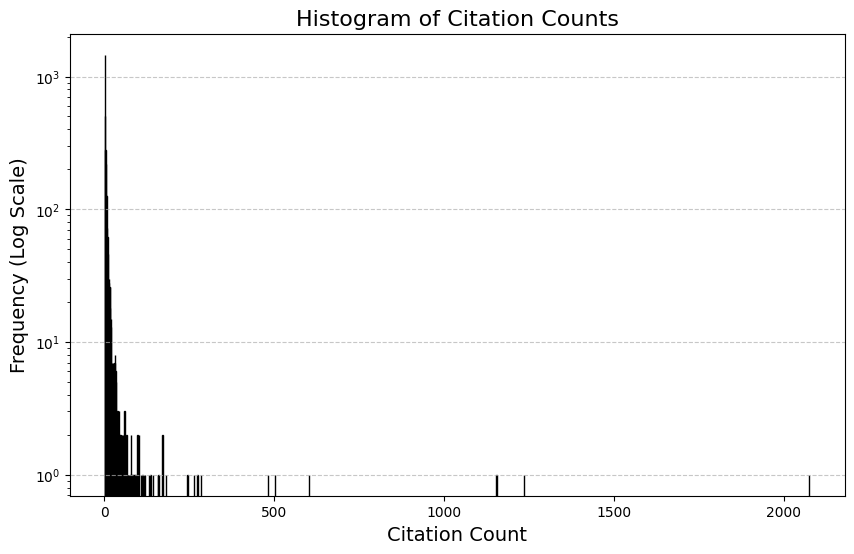

In [17]:
import matplotlib.pyplot as plt

# Assuming `df_processed['final_url'].value_counts()` is already calculated
# Get the value counts as a DataFrame
citation_counts = df_processed['final_url'].value_counts().reset_index()
citation_counts.columns = ['final_url', 'count']

# Plot the histogram of citation counts
plt.figure(figsize=(10, 6))
plt.hist(citation_counts['count'], bins=range(1, citation_counts['count'].max() + 1), edgecolor='black', log=True)
plt.title('Histogram of Citation Counts', fontsize=16)
plt.xlabel('Citation Count', fontsize=14)
plt.ylabel('Frequency (Log Scale)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [22]:
len(citation_counts[citation_counts['count']<10])/len(df_processed)

0.08635272945410918

In [23]:
citation_counts[citation_counts['count']==1]

,final_url,count
1815,https://doi.org/10.18653/v1/2023.acl-short.75,1
1816,https://arxiv.org/pdf/arXiv:2409.10819.pdf,1
1817,https://doi.org/10.48550/arXiv.2012.02951,1
1818,https://arxiv.org/pdf/2410.12490.pdf,1
1819,https://arxiv.org/pdf/arXiv:2410.06885.pdf,1
...,...,...
3270,https://arxiv.org/pdf/2409.20196.pdf,1
3271,https://hal.science/hal-04160733,1
3272,https://doi.org/10.48550/arXiv.2212.10440,1
3273,https://doi.org/10.1109/INISTA52262.2021.9548335,1


In [24]:
df_processed['final_url'].value_counts()

final_url
https://doi.org/10.48550/ARXIV.2209.11055           2076
https://arxiv.org/abs/1908.10084                    1236
https://www.arxiv.org/abs/2408.10441                1154
https://doi.org/10.21437/Interspeech.2018-1456       601
https://arxiv.org/pdf/2407.00066.pdf                 502
                                                    ... 
https://arxiv.org/pdf/2409.20196.pdf                   1
https://hal.science/hal-04160733                       1
https://doi.org/10.48550/arXiv.2212.10440              1
https://doi.org/10.1109/INISTA52262.2021.9548335       1
https://aclanthology.org/2022.parlaclarin-1.13         1
Name: count, Length: 3275, dtype: int64

In [26]:
import os
import pandas as pd
import requests
from tqdm import tqdm

# Assuming df_processed is available and contains 'final_url' and 'modelId' columns
# Replace this with the actual DataFrame loading logic if necessary
df_processed = pd.read_csv("processed_final_urls.csv")

# Create a base directory to save the PDFs
base_output_dir = "downloaded_pdfs_by_model"
os.makedirs(base_output_dir, exist_ok=True)

# Helper function to download a PDF
def download_pdf(url, output_path):
    if os.path.exists(output_path):
        return output_path  # Skip downloading if file exists
    try:
        response = requests.get(url, stream=True, timeout=10)
        if response.status_code == 200 and "application/pdf" in response.headers.get("Content-Type", ""):
            with open(output_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=1024):
                    f.write(chunk)
            return output_path
        else:
            return None
    except Exception as e:
        return None

# Prepare a list to store download information
download_info = []
# Iterate through the final_url column and download PDFs
for index, row in tqdm(df_processed.iterrows(), total=len(df_processed)):
    url = row['final_url']
    model_id = row['modelId']  # Ensure 'modelId' column exists in df_processed
    if pd.notna(url) and pd.notna(model_id):
        # Create a subdirectory for the current modelId
        model_dir = os.path.join(base_output_dir, model_id)
        os.makedirs(model_dir, exist_ok=True)
        # Generate a safe filename
        file_name = os.path.basename(url.split('/')[-1])
        file_path = os.path.join(model_dir, file_name)
        # Download the PDF
        downloaded_path = download_pdf(url, file_path)
        # Append to download info
        download_info.append({
            "modelId": model_id,
            "final_url": url,
            "local_path": downloaded_path if downloaded_path else None
        })

# Create a DataFrame for download info and save it as a CSV
download_info_df = pd.DataFrame(download_info)
download_info_df.to_csv("downloaded_pdfs_by_model_info.csv", index=False)


  6%|▌         | 1878/33340 [14:19<3:59:56,  2.19it/s]  


KeyboardInterrupt: 

In [32]:
df_split_temp = pd.read_parquet('data/modelcard_step3_markdown_gated.parquet')
df_split_temp

,modelId,author,last_modified,downloads,likes,library_name,tags,pipeline_tag,createdAt,card,...,card_tags_new_version,card_tags_pipeline_tag,card_tags_library_name,card_tags_tags,card_tags_datasets,analysis_keyword_status,detected_keywords,is_default_card,contains_markdown_table,extracted_markdown_table
0,sentence-transformers/all-mpnet-base-v2,sentence-transformers,2024-11-05 15:25:48+00:00,391757489,874,sentence-transformers,"[sentence-transformers, pytorch, onnx, safeten...",sentence-similarity,2022-03-02,---\nlanguage: en\nlicense: apache-2.0\nlibrar...,...,None,sentence-similarity,sentence-transformers,"[sentence-transformers, feature-extraction, se...","s2orc, flax-sentence-embeddings/stackexchange_...",none,[],False,True,| Dataset ...
1,nesaorg/benchmark_v0,nesaorg,2024-08-19 18:24:49+00:00,98012579,1,None,"[safetensors, model_hub_mixin, pytorch_model_h...",None,2024-08-13,---\ntags:\n- model_hub_mixin\n- pytorch_model...,...,None,None,None,"[model_hub_mixin, pytorch_model_hub_mixin]",None,none,[],False,False,None
2,sentence-transformers/all-MiniLM-L6-v2,sentence-transformers,2024-11-01 10:26:30+00:00,74110727,2526,sentence-transformers,"[sentence-transformers, pytorch, tf, rust, onn...",sentence-similarity,2022-03-02,---\nlanguage: en\nlicense: apache-2.0\nlibrar...,...,None,sentence-similarity,sentence-transformers,"[sentence-transformers, feature-extraction, se...","s2orc, flax-sentence-embeddings/stackexchange_...",none,[],False,True,| Dataset ...
3,google-bert/bert-base-uncased,google-bert,2024-02-19 11:06:12+00:00,61569952,1897,transformers,"[transformers, pytorch, tf, jax, rust, coreml,...",fill-mask,2022-03-02,---\nlanguage: en\ntags:\n- exbert\nlicense: a...,...,None,None,None,[exbert],"bookcorpus, wikipedia",none,[],False,True,| Model | #params | Language |\n|-------------...
4,FacebookAI/xlm-roberta-large,FacebookAI,2024-02-19 12:48:30+00:00,57186100,345,transformers,"[transformers, pytorch, tf, jax, onnx, safeten...",fill-mask,2022-03-02,---\ntags:\n- exbert\nlanguage:\n- multilingua...,...,None,None,None,[exbert],None,none,[],False,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108754,barchetta/baco-131233,barchetta,2024-11-13 01:33:00+00:00,0,0,None,[region:us],None,2024-11-13,Entry not found,...,None,None,None,[],None,none,[],False,False,None
1108755,saqqdy/Qwen-Qwen1.5-0.5B-1731461591,saqqdy,2024-11-13 01:33:19+00:00,0,0,peft,"[peft, safetensors, arxiv:1910.09700, base_mod...",None,2024-11-13,---\nbase_model: Qwen/Qwen1.5-0.5B\nlibrary_na...,...,None,None,peft,[],None,none,[],True,False,None
1108756,minhaozhang/Llama-3.2-1B-Instruct-MBTI-JP,minhaozhang,2024-11-13 01:33:17+00:00,0,0,None,[region:us],None,2024-11-13,Entry not found,...,None,None,None,[],None,none,[],False,False,None
1108757,mradermacher/Mistral-quiet-star-demo-GGUF,mradermacher,2024-11-13 01:33:42+00:00,0,0,None,[region:us],None,2024-11-13,---\nbase_model: liminerity/Mistral-quiet-star...,...,None,None,transformers,"[text-generation-inference, transformers, unsl...",gate369/Alpaca-Star,none,[],False,True,| Link | Type | Size/GB | Notes |\n|:-----|:--...


In [33]:
# then download the github readme files for all files
# first get github links
from urllib.parse import urlparse
import pandas as pd
import re

# Valid PDF link domains
VALID_PDF_LINKS = [
    "arxiv.org",
    "biorxiv.org",
    "medrxiv.org",
    "dl.acm.org",
    "dblp.uni-trier.de",
    "scholar.google.com",
    "pubmed.ncbi.nlm.nih.gov",
    "frontiersin.org",
    "mdpi.com",
    "cvpr.thecvf.com",
    "nips.cc",
    "icml.cc",
    "ijcai.org",
    "webofscience.com",
    "journals.plos.org",
    "nature.com",
    "semanticscholar.org",
    "chemrxiv.org",
    "link.springer.com",
    "ieeexplore.ieee.org",
    "aaai.org",
    "openaccess.thecvf.com",
]

# Function to extract links from text
def extract_links(text):
    """Extract PDF and GitHub links from the text."""
    if pd.isna(text):
        return {"pdf_link": None, "github_link": None, "all_links": []}
    
    # Find all links (match https://, http://, and www.)
    all_links = [link.strip(".,)") for link in re.findall(r"(https?://\S+|www\.\S+)", text)]
    # Function to check if the link is a valid PDF link, excluding specific ones
    def is_valid_pdf_link(link):
        """
        Check if a link is a valid PDF link:
        1. Matches one of the predefined VALID_PDF_LINKS domains;
        2. Ends with ".pdf";
        3. Allows 'arxiv:1910.09700' but still requires other valid PDF links.
        """
        try:
            parsed_url = urlparse(link)
            domain = parsed_url.netloc.lstrip("www.")  # Remove "www." prefix
        except Exception:
            return False  # Invalid link
        # If the link is 'arxiv:1910.09700', allow it but still need another valid link
        return (domain in VALID_PDF_LINKS or link.lower().endswith(".pdf"))

    # Filter PDF and GitHub links
    pdf_links = [link for link in all_links if is_valid_pdf_link(link)]
    github_links = [link for link in all_links if "github.com" in link]
    # If 'arxiv:1910.09700' is found, ensure there are other valid PDF links
    has_arxiv_1910 = any("arxiv:1910.09700" in link for link in all_links)
    if has_arxiv_1910 and len(pdf_links) == 1 and "arxiv:1910.09700" in pdf_links:
        pdf_links = []  # Exclude arxiv:1910.09700 if no other valid link exists
    # Return results
    return {
        "pdf_link": pdf_links if pdf_links else None,
        "github_link": github_links if github_links else None,
        "all_links": all_links if all_links else None
    }

# Ensure the 'card_readme' column is filled with an empty string if it's NaN
df_split_temp['combined_text'] = df_split_temp['card_readme'].fillna('')

# Apply the link extraction function
results = df_split_temp['combined_text'].apply(extract_links)

# Extract the results into separate columns
df_split_temp['pdf_link'] = results.apply(lambda x: x["pdf_link"] if x["pdf_link"] else None)
df_split_temp['github_link'] = results.apply(lambda x: x["github_link"] if x["github_link"] else None)
df_split_temp['all_links'] = results.apply(lambda x: ', '.join(x["all_links"]) if x["all_links"] else None)

# Check if each link type column has a non-empty value (avoids empty strings, lists, or NaNs)
df_split_temp['all_links_non_empty'] = df_split_temp['all_links'].apply(lambda x: bool(x) and x != '[]' and x != '')
df_split_temp['pdf_link_non_empty'] = df_split_temp['pdf_link'].apply(lambda x: bool(x) and x != '[]' and x != '')
df_split_temp['github_link_non_empty'] = df_split_temp['github_link'].apply(lambda x: bool(x) and x != '[]' and x != '')

# Count the occurrences and calculate the ratios
pdf_link_count = df_split_temp['pdf_link_non_empty'].sum()
total_count = len(df_split_temp)
pdf_link_ratio = (pdf_link_count / total_count) * 100

# Count rows where 'all_links' is non-empty
all_link_count = df_split_temp['all_links_non_empty'].sum()
all_link_ratio = (all_link_count / total_count) * 100

github_link_count = df_split_temp['github_link_non_empty'].sum()
github_link_ratio = (github_link_count / total_count) * 100

# Count entries with no PDF but with GitHub links
no_pdf_has_github_count = df_split_temp[~df_split_temp['pdf_link_non_empty'] & df_split_temp['github_link_non_empty']].shape[0]
no_pdf_has_github_ratio = (no_pdf_has_github_count / total_count) * 100

# Output the results
print(f"Model cards with all links: {all_link_count}/{total_count} = {all_link_ratio:.2f}%")
print(f"Model cards with GitHub links: {github_link_count}/{total_count} = {github_link_ratio:.2f}%")
print(f"Model cards with PDF links: {pdf_link_count}/{total_count} = {pdf_link_ratio:.2f}%")
print(f"Model cards with NO PDF but HAS GitHub links: "
      f"{no_pdf_has_github_count}/{total_count} = {no_pdf_has_github_ratio:.2f}%")


Model cards with all links: 580229/1108759 = 52.33%
Model cards with GitHub links: 194586/1108759 = 17.55%
Model cards with PDF links: 226015/1108759 = 20.38%
Model cards with NO PDF but HAS GitHub links: 158688/1108759 = 14.31%


In [35]:
df_split_temp[~df_split_temp['github_link'].isna()]

,modelId,author,last_modified,downloads,likes,library_name,tags,pipeline_tag,createdAt,card,...,is_default_card,contains_markdown_table,extracted_markdown_table,combined_text,pdf_link,github_link,all_links,all_links_non_empty,pdf_link_non_empty,github_link_non_empty
0,sentence-transformers/all-mpnet-base-v2,sentence-transformers,2024-11-05 15:25:48+00:00,391757489,874,sentence-transformers,"[sentence-transformers, pytorch, onnx, safeten...",sentence-similarity,2022-03-02,---\nlanguage: en\nlicense: apache-2.0\nlibrar...,...,False,True,| Dataset ...,# all-mpnet-base-v2\nThis is a [sentence-trans...,"[https://arxiv.org/abs/1904.06472, https://arx...",[https://github.com/PolyAI-LDN/conversational-...,"https://www.SBERT.net, https://www.SBERT.net, ...",True,True,True
2,sentence-transformers/all-MiniLM-L6-v2,sentence-transformers,2024-11-01 10:26:30+00:00,74110727,2526,sentence-transformers,"[sentence-transformers, pytorch, tf, rust, onn...",sentence-similarity,2022-03-02,---\nlanguage: en\nlicense: apache-2.0\nlibrar...,...,False,True,| Dataset ...,# all-MiniLM-L6-v2\nThis is a [sentence-transf...,"[https://arxiv.org/abs/1904.06472, https://arx...",[https://github.com/PolyAI-LDN/conversational-...,"https://www.SBERT.net, https://www.SBERT.net, ...",True,True,True
3,google-bert/bert-base-uncased,google-bert,2024-02-19 11:06:12+00:00,61569952,1897,transformers,"[transformers, pytorch, tf, jax, rust, coreml,...",fill-mask,2022-03-02,---\nlanguage: en\ntags:\n- exbert\nlicense: a...,...,False,True,| Model | #params | Language |\n|-------------...,# BERT base model (uncased)\n\nPretrained mode...,"[https://arxiv.org/abs/1810.04805, http://arxi...","[https://github.com/google-research/bert, http...","https://arxiv.org/abs/1810.04805, https://gith...",True,True,True
4,FacebookAI/xlm-roberta-large,FacebookAI,2024-02-19 12:48:30+00:00,57186100,345,transformers,"[transformers, pytorch, tf, jax, onnx, safeten...",fill-mask,2022-03-02,---\ntags:\n- exbert\nlanguage:\n- multilingua...,...,False,False,None,# XLM-RoBERTa (large-sized model) \n\nXLM-RoBE...,"[https://arxiv.org/abs/1911.02116, http://arxi...",[https://github.com/pytorch/fairseq/tree/maste...,"https://arxiv.org/abs/1911.02116, https://gith...",True,True,True
5,openai/whisper-large-v2,openai,2024-02-29 10:57:50+00:00,44239856,1649,transformers,"[transformers, pytorch, tf, jax, safetensors, ...",automatic-speech-recognition,2022-12-05,---\nlanguage: \n- en\n- zh\n- de\n- es\n- ru\...,...,False,True,| Size | Parameters | English-only ...,# Whisper\n\nWhisper is a pre-trained model fo...,"[https://arxiv.org/abs/2212.04356, https://cdn...",[https://github.com/openai/whisper],"https://arxiv.org/abs/2212.04356, https://gith...",True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108731,bau0221/1113_model_1,bau0221,2024-11-13 01:25:10+00:00,0,0,transformers,"[transformers, safetensors, text-generation-in...",None,2024-11-13,---\nbase_model: unsloth/phi-3.5-mini-instruct...,...,False,False,None,# Uploaded model\n\n- **Developed by:** bau02...,None,"[https://github.com/unslothai/unsloth, https:/...","https://github.com/unslothai/unsloth, https://...",True,False,True
1108736,benito14/1B_finetuned_llama3.2,benito14,2024-11-13 01:27:44+00:00,0,0,transformers,"[transformers, safetensors, text-generation-in...",None,2024-11-13,---\nbase_model: unsloth/Llama-3.2-1B-bnb-4bit...,...,False,False,None,# Uploaded model\n\n- **Developed by:** benit...,None,"[https://github.com/unslothai/unsloth, https:/...","https://github.com/unslothai/unsloth, https://...",True,False,True
1108740,async0x42/Qwen2.5-Coder-32B-Instruct-exl2_4.0bpw,async0x42,2024-11-13 01:28:25+00:00,0,0,None,[region:us],None,2024-11-13,---\nlicense: apache-2.0\nlicense_link: https:...,...,False,False,None,# Qwen2.5-Coder-32B-Instruct\n\n## Introductio...,"[https://arxiv.org/abs/2409.12186, https://arx...",[https://github.com/QwenLM/Qwen2.5-Coder],https://qwenlm.github.io/blog/qwen2.5-co

In [38]:
df_split_temp.to_csv('data/tmp_df_split_temp.csv')

In [ ]:
df_split_temp = pd.read_csv('data/tmp_df_split_temp.csv')

In [39]:
import os
import pandas as pd
import requests
from tqdm import tqdm

# Assuming df_split_temp is available and contains 'github_link' and 'modelId' columns
# Replace this with actual DataFrame loading if necessary
#df_split_temp = pd.read_parquet('data/modelcard_step3_markdown_gated.parquet')
df_split_temp = pd.read_csv('data/tmp_df_split_temp.csv')

# Create a base directory to save the READMEs
base_output_dir = "github_readmes"
os.makedirs(base_output_dir, exist_ok=True)

# Helper function to download the README file
def download_readme(github_url, output_path):
    try:
        # Ensure the URL is valid and not a list
        if isinstance(github_url, list):
            github_url = github_url[0]  # Take the first URL from the list
        # Construct raw.githubusercontent.com link
        raw_url = github_url.replace("github.com", "raw.githubusercontent.com").rstrip("/") + "/main/README.md"
        response = requests.get(raw_url, timeout=10)
        if response.status_code == 200:  # File exists
            with open(output_path, "w", encoding="utf-8") as f:
                f.write(response.text)
            return output_path
        else:
            print(f"Error: Unable to download README from {raw_url}. Status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error: Exception occurred while downloading {github_url} - {e}")
        return None

# Prepare a list to store download information
download_info = []
# Iterate through the GitHub links and download READMEs
for index, row in tqdm(df_split_temp.iterrows(), total=len(df_split_temp)):
    github_link = row['github_link']
    model_id = row['modelId']
    # Ensure github_link is a string or take the first element if it's a list
    if isinstance(github_link, list) and len(github_link) > 0:
        github_link = github_link[0]  # Take the first URL from the list
    elif not isinstance(github_link, str):
        print(f"Skipping invalid github_link for modelId {model_id}: {github_link}")
        continue
    if pd.notna(github_link) and pd.notna(model_id):
        # Create a subdirectory for the current modelId
        model_dir = os.path.join(base_output_dir, model_id)
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
            print(f"Directory created: {model_dir}")
        else:
            print(f"Directory exists: {model_dir}")
        # Target file path
        readme_path = os.path.join(model_dir, "README.md")
        # Check if the README file already exists
        if os.path.exists(readme_path):
            print(f"README already exists for modelId {model_id}, skipping download.")
            downloaded_path = readme_path
        else:
            # Download the README file
            downloaded_path = download_readme(github_link, readme_path)
        # Save download information
        download_info.append({
            "modelId": model_id,
            "github_link": github_link,
            "readme_path": downloaded_path if downloaded_path else None
        })

# Create a DataFrame for download information and save it to a CSV
download_info_df = pd.DataFrame(download_info)
download_info_df.to_csv("github_readmes_info.csv", index=False)

# Print summary
print(f"Downloaded {len([d for d in download_info if d['readme_path']])} READMEs.")
print(f"Skipped {len([d for d in download_info if not d['readme_path']])} READMEs.")

In [36]:
#df_split_temp[~df_split_temp['github_link'].isna()]

,modelId,author,last_modified,downloads,likes,library_name,tags,pipeline_tag,createdAt,card,...,is_default_card,contains_markdown_table,extracted_markdown_table,combined_text,pdf_link,github_link,all_links,all_links_non_empty,pdf_link_non_empty,github_link_non_empty
0,sentence-transformers/all-mpnet-base-v2,sentence-transformers,2024-11-05 15:25:48+00:00,391757489,874,sentence-transformers,"[sentence-transformers, pytorch, onnx, safeten...",sentence-similarity,2022-03-02,---\nlanguage: en\nlicense: apache-2.0\nlibrar...,...,False,True,| Dataset ...,# all-mpnet-base-v2\nThis is a [sentence-trans...,"[https://arxiv.org/abs/1904.06472, https://arx...",[https://github.com/PolyAI-LDN/conversational-...,"https://www.SBERT.net, https://www.SBERT.net, ...",True,True,True
2,sentence-transformers/all-MiniLM-L6-v2,sentence-transformers,2024-11-01 10:26:30+00:00,74110727,2526,sentence-transformers,"[sentence-transformers, pytorch, tf, rust, onn...",sentence-similarity,2022-03-02,---\nlanguage: en\nlicense: apache-2.0\nlibrar...,...,False,True,| Dataset ...,# all-MiniLM-L6-v2\nThis is a [sentence-transf...,"[https://arxiv.org/abs/1904.06472, https://arx...",[https://github.com/PolyAI-LDN/conversational-...,"https://www.SBERT.net, https://www.SBERT.net, ...",True,True,True
3,google-bert/bert-base-uncased,google-bert,2024-02-19 11:06:12+00:00,61569952,1897,transformers,"[transformers, pytorch, tf, jax, rust, coreml,...",fill-mask,2022-03-02,---\nlanguage: en\ntags:\n- exbert\nlicense: a...,...,False,True,| Model | #params | Language |\n|-------------...,# BERT base model (uncased)\n\nPretrained mode...,"[https://arxiv.org/abs/1810.04805, http://arxi...","[https://github.com/google-research/bert, http...","https://arxiv.org/abs/1810.04805, https://gith...",True,True,True
4,FacebookAI/xlm-roberta-large,FacebookAI,2024-02-19 12:48:30+00:00,57186100,345,transformers,"[transformers, pytorch, tf, jax, onnx, safeten...",fill-mask,2022-03-02,---\ntags:\n- exbert\nlanguage:\n- multilingua...,...,False,False,None,# XLM-RoBERTa (large-sized model) \n\nXLM-RoBE...,"[https://arxiv.org/abs/1911.02116, http://arxi...",[https://github.com/pytorch/fairseq/tree/maste...,"https://arxiv.org/abs/1911.02116, https://gith...",True,True,True
5,openai/whisper-large-v2,openai,2024-02-29 10:57:50+00:00,44239856,1649,transformers,"[transformers, pytorch, tf, jax, safetensors, ...",automatic-speech-recognition,2022-12-05,---\nlanguage: \n- en\n- zh\n- de\n- es\n- ru\...,...,False,True,| Size | Parameters | English-only ...,# Whisper\n\nWhisper is a pre-trained model fo...,"[https://arxiv.org/abs/2212.04356, https://cdn...",[https://github.com/openai/whisper],"https://arxiv.org/abs/2212.04356, https://gith...",True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108731,bau0221/1113_model_1,bau0221,2024-11-13 01:25:10+00:00,0,0,transformers,"[transformers, safetensors, text-generation-in...",None,2024-11-13,---\nbase_model: unsloth/phi-3.5-mini-instruct...,...,False,False,None,# Uploaded model\n\n- **Developed by:** bau02...,None,"[https://github.com/unslothai/unsloth, https:/...","https://github.com/unslothai/unsloth, https://...",True,False,True
1108736,benito14/1B_finetuned_llama3.2,benito14,2024-11-13 01:27:44+00:00,0,0,transformers,"[transformers, safetensors, text-generation-in...",None,2024-11-13,---\nbase_model: unsloth/Llama-3.2-1B-bnb-4bit...,...,False,False,None,# Uploaded model\n\n- **Developed by:** benit...,None,"[https://github.com/unslothai/unsloth, https:/...","https://github.com/unslothai/unsloth, https://...",True,False,True
1108740,async0x42/Qwen2.5-Coder-32B-Instruct-exl2_4.0bpw,async0x42,2024-11-13 01:28:25+00:00,0,0,None,[region:us],None,2024-11-13,---\nlicense: apache-2.0\nlicense_link: https:...,...,False,False,None,# Qwen2.5-Coder-32B-Instruct\n\n## Introductio...,"[https://arxiv.org/abs/2409.12186, https://arx...",[https://github.com/QwenLM/Qwen2.5-Coder],https://qwenlm.github.io/blog/qwen2.5-co

In [15]:
df_processed[df_processed['final_url']=='https://doi.org/10.48550/ARXIV.2209.11055']['modelId']

1144                  Decius/botpress_Vaganet_new_model
1362     tstadel/answer-classification-setfit-v2-binary
1855                          nikcheerla/amd-partial-v1
1858                nikcheerla/amd-partial-phonetree-v1
1864                   nikcheerla/amd-full-phonetree-v1
                              ...                      
32962                nghodki/setfit-sre-task-classifier
33259                           adriansanz/greeetings-2
33273                                  adriansanz/gret3
33275                                  adriansanz/gret4
33279                                  adriansanz/gret5
Name: modelId, Length: 2076, dtype: object

In [160]:
# Filter rows without pdf_type
missing_pdf_type = df_processed[df_processed['pdf_type'].isnull()]

# Print the number of rows without pdf_type
print(f"Entries without pdf_type: {len(missing_pdf_type)}")

# Print a sample row to inspect the bibtex_entry
sample_row = missing_pdf_type.sample(1)
print("Sample BibTeX Entry Without PDF Type:")
print(sample_row['bibtex_entry'].iloc[0])


Entries without pdf_type: 9076
Sample BibTeX Entry Without PDF Type:
@misc{louisbrulenaudet2024, author =       {Louis Brulé Naudet}, title =        {Maxine-7B-0401-stock, an xtraordinary 7B model}, year =         {2024} howpublished = {\url{https://huggingface.co/louisbrulenaudet/Maxine-7B-0401-stock}}, }


In [41]:
df_processed[(df_processed['pdf_type'].notna()) & (df_processed['pdf_type'].isin(['unknown']))]

,index,bibtex_entry,pdf_type,pdf_link
88,88,"@online{emb2024mxbai,\n title={Open Source St...",unknown,https://www.mixedbread.ai/blog/mxbai-embed-lar...
121,121,"@article{llama3modelcard,\n\n title={Llama 3 ...",unknown,https://github.com/meta-llama/llama3/blob/main...
176,176,"@article{llama3modelcard,\n\n title={Llama 3 ...",unknown,https://github.com/meta-llama/llama3/blob/main...
220,220,"@software{text2vec,\n author = {Xu Ming},\n ...",unknown,https://github.com/shibing624/text2vec
345,345,"@article{llama3modelcard,\n\n title={Llama 3 ...",unknown,https://github.com/meta-llama/llama3/blob/main...
...,...,...,...,...
1100899,1100899,"@software{bayram_2024_tr_tokenizer,\n author ...",unknown,https://huggingface.co/alibayram/tr_tokenizer
1104817,1104817,"@online{kexuefm-8847,\n title={CoSENT: A mo...",unknown,https://kexue.fm/archives/8847
1106196,1106196,"@misc{sebastian_gabarain_2024,\n title = {Hyp...",unknown,https://huggingface.co/datasets/Locutusque/hyp...
1106813,1106813,"@misc{elyzallama2024,\n title={elyza/Llam...",unknown,https://huggingface.co/elyza/Llama-3-ELYZA-JP-8B


In [43]:
from urllib.parse import urlparse

df_processed_clean = df_processed.copy()
df_processed_clean['domain'] = df_processed_clean[df_processed_clean['pdf_type']=='unknown']['pdf_link'].apply(lambda x: urlparse(x).netloc if pd.notna(x) else None)
# Count the domains
domain_counts = df_processed_clean['domain'].value_counts()
domain_counts.index

Index(['github.com', 'huggingface.co', '', 'www.aclweb.org', 'kexue.fm',
       'www.databricks.com', 'nexusflow.ai', 'api.semanticscholar.org',
       'cohere.com', 'sol.sbc.org.br', 'fauconnier.github.io',
       'llava-vl.github.io', 'drive.google.com', 'www.microsoft.com',
       'vicuna.lmsys.org', 'inria.hal.science', 'www.mixedbread.ai',
       'riffusion.com', 'goo.gle', 'paloma.allen.ai', 'gradient.ai',
       'arcinstitute.org', 'esemi.org', 'blog.salesforceairesearch.com',
       'aihealth.site', 'www.silma.ai', 'swallow-llm.github.io',
       'datacommons.org', 'https:', 'kb-labb.github.io', 'medium.com',
       'ai.meta.com', 'clin33.uantwerpen.be', 'hal.science',
       'www.techmahindra.com', 'getlinq.com', 'jordandarefsky.com', 'hf.co',
       'www.github.com', 'www.clinjournal.org', 'kangaroogroup.github.io',
       'hal.inria.fr', 'papers.ssrn.com', 'www.igi-global.com',
       'huggingface.coLowerated', 'dh2022.dhii.asia', 'devmount.github.io',
       'scholars.cityu

### findings
arxiv links can trust, doi links can trust, links starts with 

In [ ]:
from urllib.parse import urlparse
import pandas as pd
import re

# Valid PDF link domains
VALID_PDF_LINKS = [
    "arxiv.org",
    "biorxiv.org",
    "medrxiv.org",
    "dl.acm.org",
    "dblp.uni-trier.de",
    "scholar.google.com",
    "pubmed.ncbi.nlm.nih.gov",
    "frontiersin.org",
    "mdpi.com",
    "cvpr.thecvf.com",
    "nips.cc",
    "icml.cc",
    "ijcai.org",
    "webofscience.com",
    "journals.plos.org",
    "nature.com",
    "semanticscholar.org",
    "chemrxiv.org",
    "link.springer.com",
    "ieeexplore.ieee.org",
    "aaai.org",
    "openaccess.thecvf.com",
]

# Function to extract links from text
def extract_links(text):
    """Extract PDF and GitHub links from the text."""
    if pd.isna(text):
        return {"pdf_link": None, "github_link": None, "all_links": []}
    
    # Find all links (match https://, http://, and www.)
    all_links = [link.strip(".,)") for link in re.findall(r"(https?://\S+|www\.\S+)", text)]
    
    # Function to check if the link is a valid PDF link, excluding specific ones
    def is_valid_pdf_link(link):
        """
        Check if a link is a valid PDF link:
        1. Matches one of the predefined VALID_PDF_LINKS domains;
        2. Ends with ".pdf";
        3. Allows 'arxiv:1910.09700' but still requires other valid PDF links.
        """
        try:
            parsed_url = urlparse(link)
            domain = parsed_url.netloc.lstrip("www.")  # Remove "www." prefix
        except Exception:
            return False  # Invalid link

        return (domain in VALID_PDF_LINKS or link.lower().endswith(".pdf"))
    pdf_links = [link for link in all_links if is_valid_pdf_link(link)]
    github_links = [link for link in all_links if "github.com" in link]
    has_arxiv_1910 = any("arxiv:1910.09700" in link for link in all_links)
    if has_arxiv_1910 and len(pdf_links) == 1 and "arxiv:1910.09700" in pdf_links:
        pdf_links = []
    return {
        "pdf_link": pdf_links if pdf_links else None,
        "github_link": github_links if github_links else None,
        "all_links": all_links if all_links else None
    }

df_split_temp['combined_text'] = df_split_temp['card_readme'].fillna('')

results = df_split_temp['combined_text'].apply(extract_links)

df_split_temp['pdf_link'] = results.apply(lambda x: x["pdf_link"] if x["pdf_link"] else None)
df_split_temp['github_link'] = results.apply(lambda x: x["github_link"] if x["github_link"] else None)
df_split_temp['all_links'] = results.apply(lambda x: ', '.join(x["all_links"]) if x["all_links"] else None)

df_split_temp['all_links_non_empty'] = df_split_temp['all_links'].apply(lambda x: bool(x) and x != '[]' and x != '')
df_split_temp['pdf_link_non_empty'] = df_split_temp['pdf_link'].apply(lambda x: bool(x) and x != '[]' and x != '')
df_split_temp['github_link_non_empty'] = df_split_temp['github_link'].apply(lambda x: bool(x) and x != '[]' and x != '')

pdf_link_count = df_split_temp['pdf_link_non_empty'].sum()
total_count = len(df_split_temp)
pdf_link_ratio = (pdf_link_count / total_count) * 100

all_link_count = df_split_temp['all_links_non_empty'].sum()
all_link_ratio = (all_link_count / total_count) * 100

github_link_count = df_split_temp['github_link_non_empty'].sum()
github_link_ratio = (github_link_count / total_count) * 100

no_pdf_has_github_count = df_split_temp[~df_split_temp['pdf_link_non_empty'] & df_split_temp['github_link_non_empty']].shape[0]
no_pdf_has_github_ratio = (no_pdf_has_github_count / total_count) * 100

print(f"Model cards with all links: {all_link_count}/{total_count} = {all_link_ratio:.2f}%")
print(f"Model cards with GitHub links: {github_link_count}/{total_count} = {github_link_ratio:.2f}%")
print(f"Model cards with PDF links: {pdf_link_count}/{total_count} = {pdf_link_ratio:.2f}%")
print(f"Model cards with NO PDF but HAS GitHub links: "
      f"{no_pdf_has_github_count}/{total_count} = {no_pdf_has_github_ratio:.2f}%")


In [ ]:
# check pdf link
df_split_temp['pdf_link_flat'] = df_split_temp['pdf_link'].apply(
    lambda x: x if isinstance(x, list) else [x] if pd.notna(x) else []
)
df_split_temp_exploded = df_split_temp.explode('pdf_link_flat')
link_counts = df_split_temp_exploded['pdf_link_flat'].value_counts()
print(link_counts)


In [ ]:
df_split_temp['extracted_markdown_table'].value_counts()